This copy is using the L20C1 version of the data that I generated by re-running Derek's notebook.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
from IPython.display import display, HTML
import bbknn
import time

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

# Load in the Datasets

### Load in the 10x data

For some reason, the `h5` that I got from Derek had some issues, it was only reading it as a `view` and not an `actual`. I loaded it in and fixed it, and re-exported for easier loading later. 

In [8]:
data = dict()
data['adata'] = sc.read_10x_h5(prefix + '10x/liver3/raw_feature_bc_matrix.h5')
data['adata'] = data['adata'].copy() # for some reason, read_10x_h5 only loads a view, not an actual object. this converts to an object

data['adata_h'] = data['adata'][:, [i for i in data['adata'].var_names if i.startswith('GRCh38_')]].copy()
data['adata_h'].var_names_make_unique()

data['adata_m'] = data['adata'][:, [i for i in data['adata'].var_names if i.startswith('mm10___')]].copy()
data['adata_m'].var_names_make_unique()

reading /data/xyzeq/10x/liver3/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Visualize the knee plot to draw a cutoff for the 10x cells. There was high background in this data.

In [9]:
for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data[adata], min_counts=1)
    sc.pp.filter_genes(data[adata], min_counts=1)
    data[adata + '-filter_cells_n_counts'] = data[adata].obs['n_counts'].sort_values(ascending=False)

filtered out 533042 cells that haveless than 1 counts
filtered out 13311 genes that are detectedin less than 1 counts
filtered out 519834 cells that haveless than 1 counts
filtered out 12278 genes that are detectedin less than 1 counts


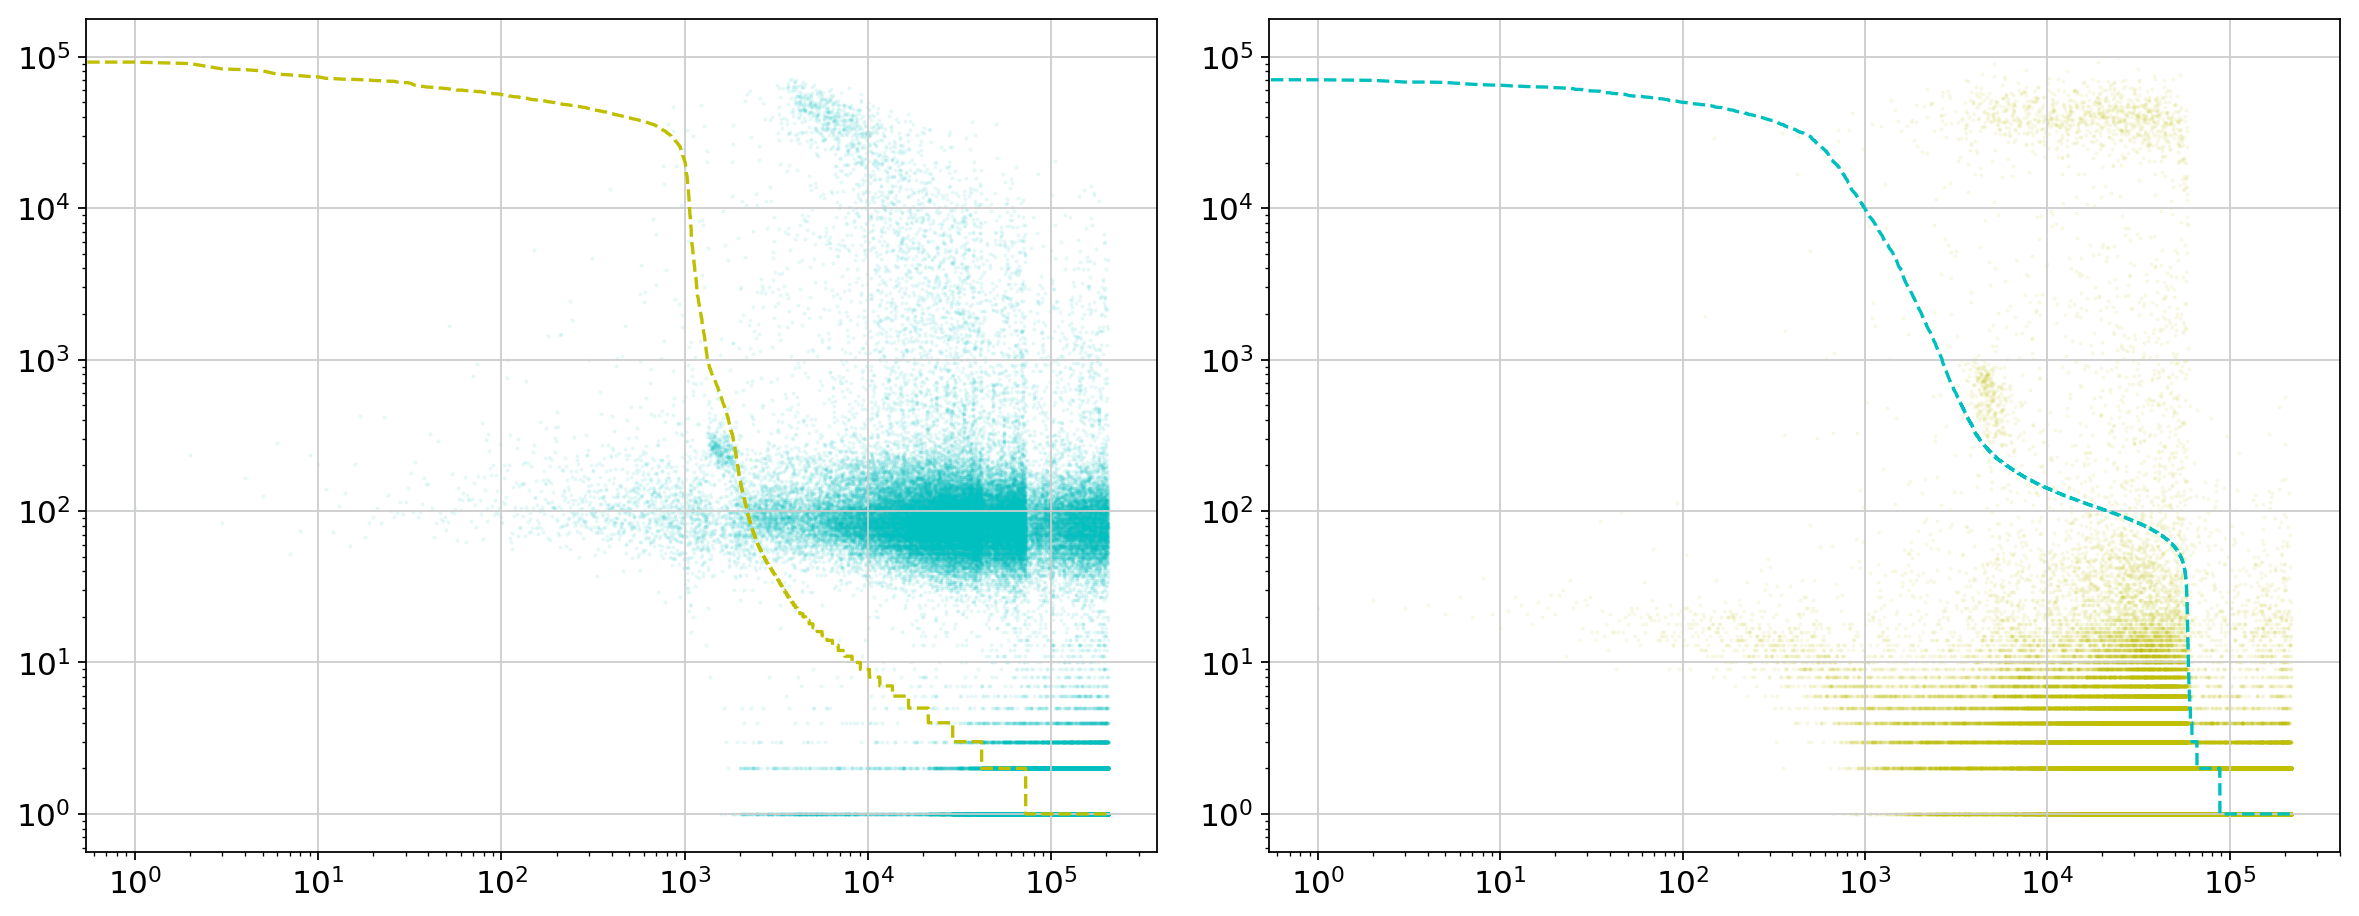

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for prod, ax in tqdm(list(zip(['adata_h', 'adata_m'], np.ravel(ax.T))), total=2):
    series = data[prod + '-filter_cells_n_counts']
    if prod == 'adata_h':
        ax.scatter(range(len(series)), data['adata_m'].obs['n_counts'][series.index.values].values, color='c', alpha=0.1, s=3, linewidth='0')
        ax.plot(series.values, color='y', linestyle='--')
    else:
        ax.scatter(range(len(series)), data['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth='0')
        ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()

In [11]:
mouse_hi_umi_cells = data['adata_m'].obs_names[data['adata_m'].obs['n_counts'] > 1e4].values
lo_umi_human_cells = data['adata_h-filter_cells_n_counts'][2000:].index.values

In [12]:
human_hi_umi_cells = data['adata_h'].obs_names[data['adata_h'].obs['n_counts'] > 1e4].values
lo_umi_mouse_cells = data['adata_m-filter_cells_n_counts'][2000:].index.values

In [13]:
mouse_cells = np.intersect1d(mouse_hi_umi_cells, lo_umi_human_cells)
human_cells = np.intersect1d(human_hi_umi_cells, lo_umi_mouse_cells)

In [14]:
data['adata_m'] = data['adata_m'][mouse_cells,:].copy()
data['adata_h'] = data['adata_h'][human_cells,:].copy()

In [15]:
data['adata_m'].var_names = [i[7:] for i in data['adata_m'].var_names]
data['adata_h'].var_names = [i[7:] for i in data['adata_h'].var_names]

Threshold %mito.

In [16]:
genelist = data['adata_m'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['adata_m'][:, mito_genes].X, axis=1))

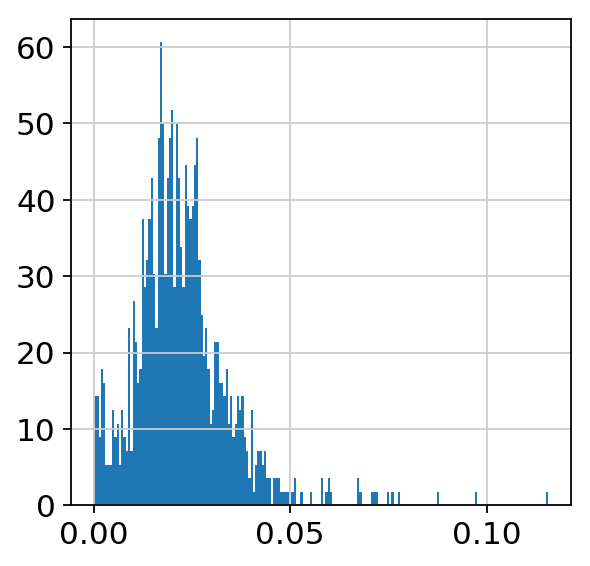

In [17]:
data['adata_m'].obs['percent_mito'] = mito_counts / data['adata_m'].obs['n_counts'].values
plt.hist(data['adata_m'].obs['percent_mito'].values,bins=200,density=True);

In [18]:
genelist = data['adata_h'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['adata_h'][:, mito_genes].X, axis=1))

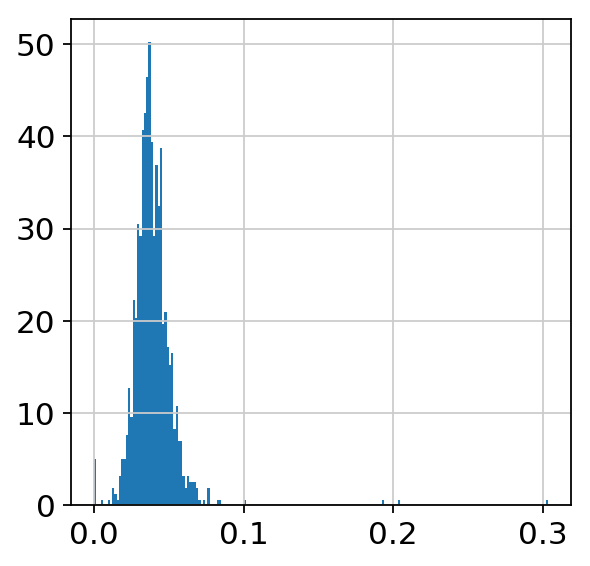

In [19]:
data['adata_h'].obs['percent_mito'] = mito_counts / data['adata_h'].obs['n_counts'].values
plt.hist(data['adata_h'].obs['percent_mito'].values,bins=200,density=True);

In [20]:
data['adata_h'] = data['adata_h'][data['adata_h'].obs['percent_mito'] < 0.1].copy()
data['adata_m'] = data['adata_m'][data['adata_m'].obs['percent_mito'] < 0.05].copy()

In [21]:
vals_h = data['adata_h'].var['n_counts'].sort_values(ascending=False).values
vals_m = data['adata_m'].var['n_counts'].sort_values(ascending=False).values

In [22]:
for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data[adata], min_counts=1)
    sc.pp.filter_genes(data[adata], min_counts=1)

filtered out 202 genes that are detectedin less than 1 counts
filtered out 1207 genes that are detectedin less than 1 counts


In [23]:
data['adata'] = data['adata_m'].concatenate(data['adata_h'],join='outer')

In [24]:
sc.pp.log1p(data['adata_m'])
sc.pp.normalize_per_cell(data['adata_m'], counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Dimensionality Reduction and Clustering

In [25]:
sc.pp.scale(data['adata_m'], max_value=10)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


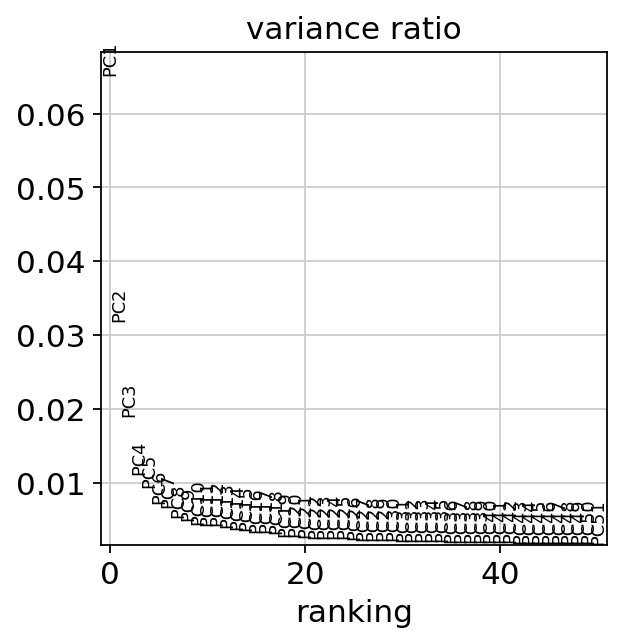

In [31]:
warnings.filterwarnings('ignore')
sc.pp.pca(data['adata_m'],n_comps=100)
sc.pl.pca_variance_ratio(data['adata_m'],log=False, n_pcs=50)
warnings.filterwarnings('default')

In [33]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(data['adata_m'],n_neighbors=15,n_pcs=12) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 12
    computed neighbors (0:00:00)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [34]:
sc.tl.umap(data['adata_m'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [40]:
sc.tl.leiden(data['adata_m'],resolution=0.2)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


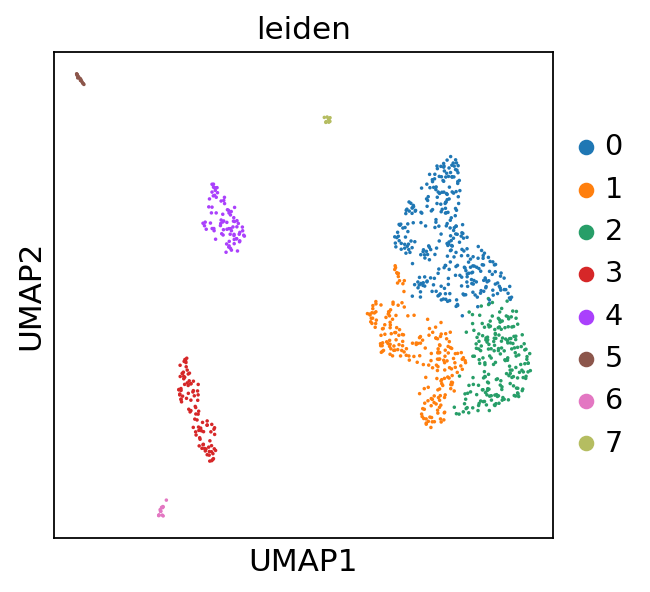

In [41]:
sc.pl.umap(data['adata_m'],color=['leiden'], size=10)

### Annotation

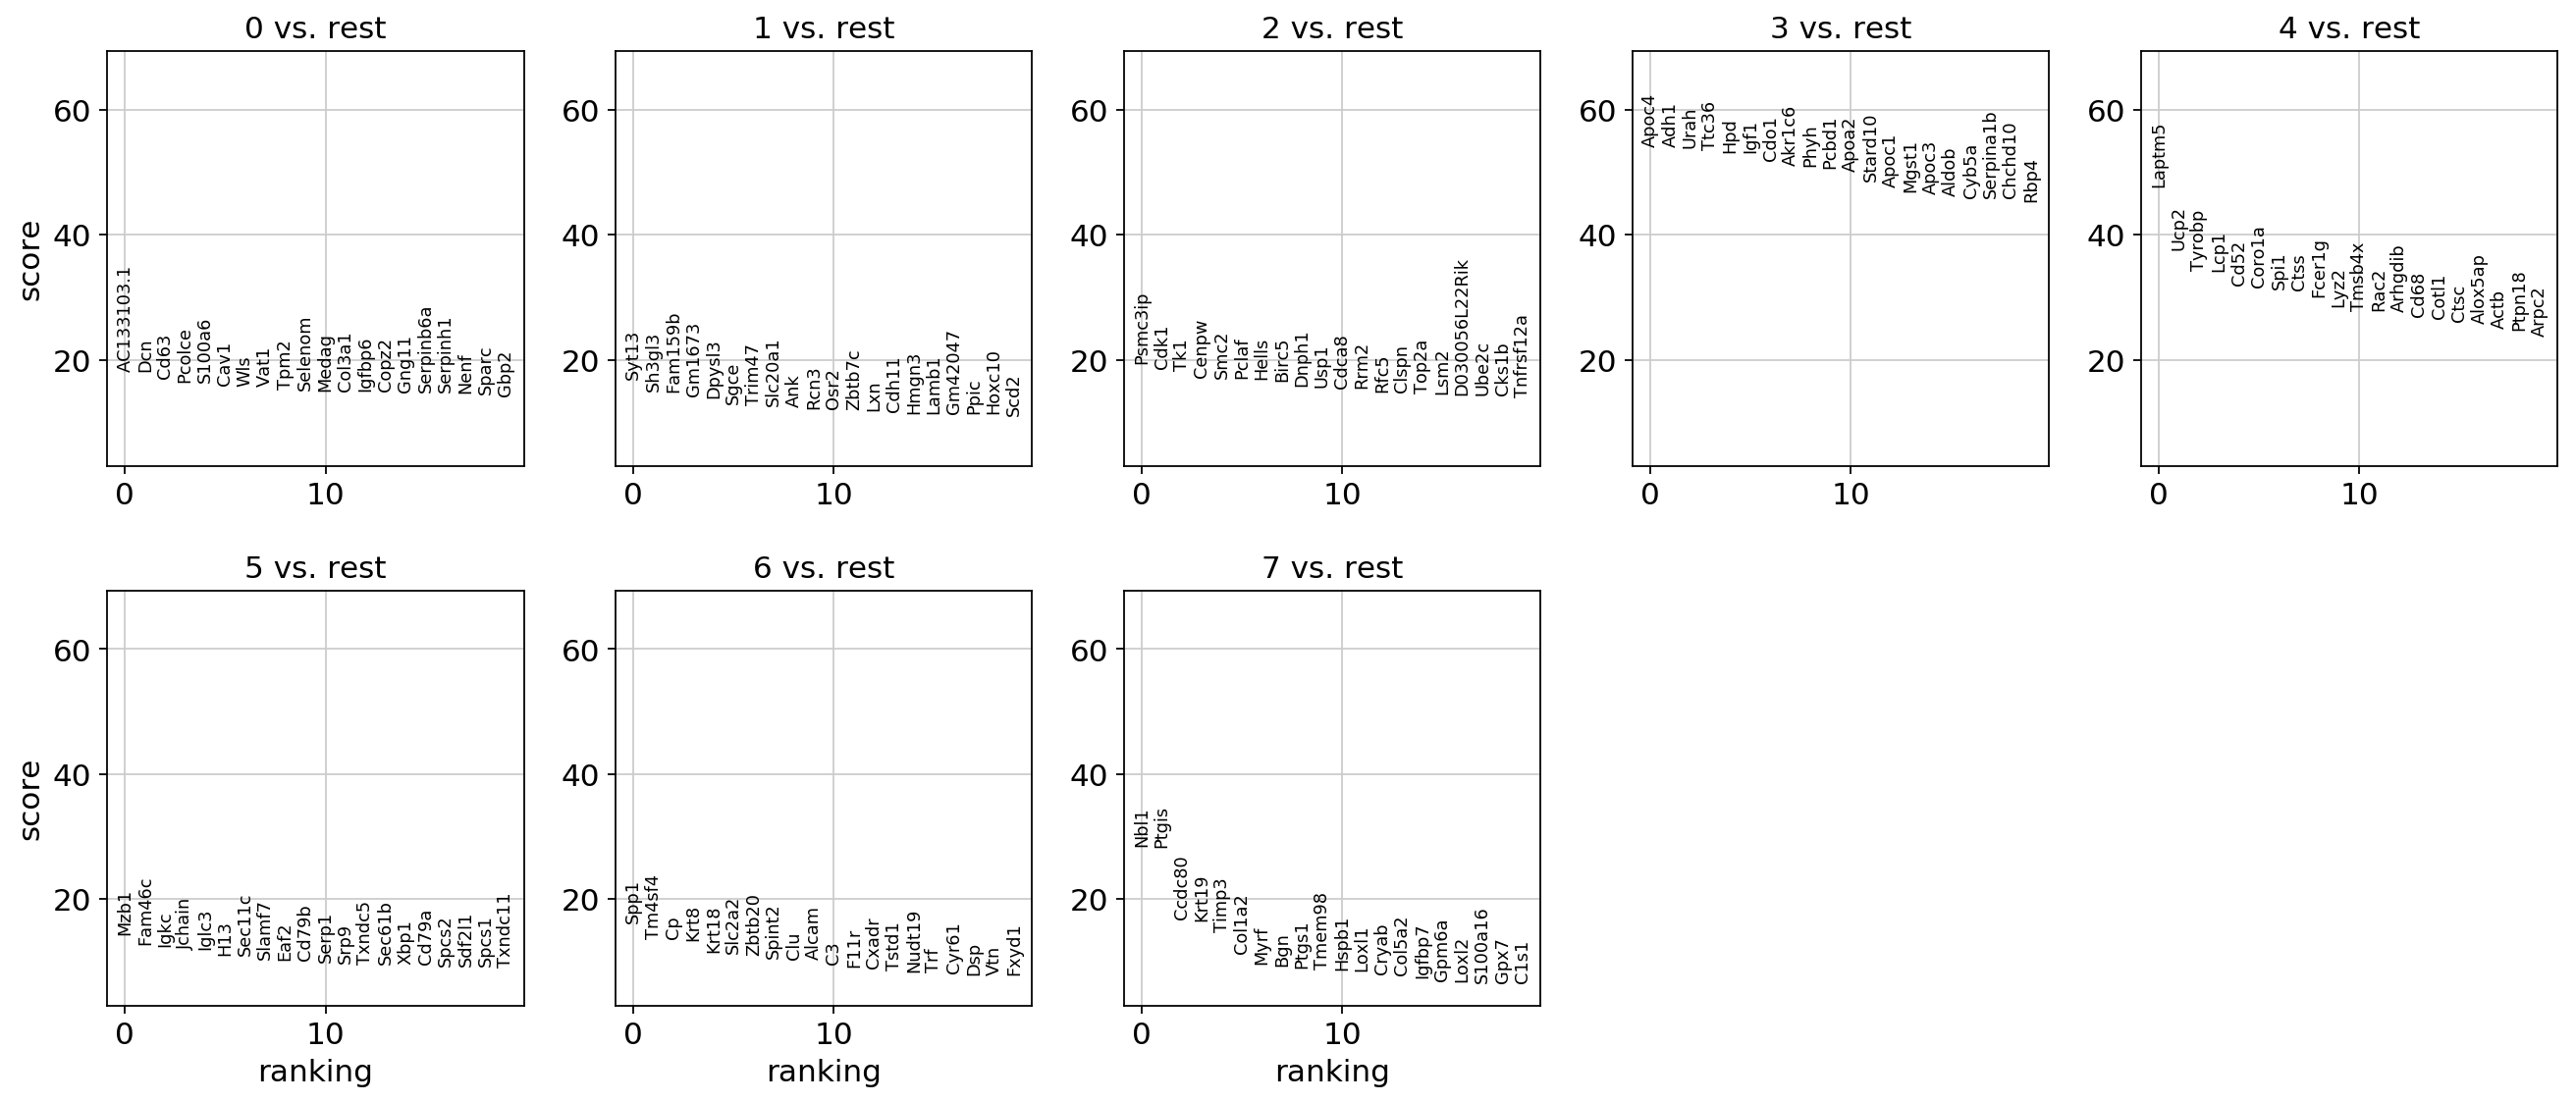

In [42]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['adata_m'], groupby='leiden', n_genes=200)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['adata_m'], ncols=5)
sc.settings.verbosity = 4

In [43]:
def make_df_from_enrichr(data):
    df = pd.DataFrame(data).set_index(0)
    df.drop([7, 8], axis=1, inplace=True)
    df.index.rename('rank', inplace=True)
    df.columns = ['term','p-value','odds ratio','combined score','genes','adjusted p-value']
    df = df[['term', 'genes','p-value']].copy()
    df['inverse p-value'] = df['p-value'].max() - df['p-value']
    return df

In [44]:
def enrichr(genelist, plot=True):
    
    def get_userListID(genelist):
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        gene_list_response = requests.post(ENRICHR_URL, files=payload)
        if not gene_list_response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(gene_list_response.text)
        userListID = data['userListId']
        return userListID
    
        
    libs = ['KEGG_2019_Mouse', 'Mouse_Gene_Atlas', 'WikiPathways_2019_Mouse', 
        'ARCHS4_Tissues', 'GO_Biological_Process_2018', 'GO_Molecular_Function_2018',
        'GO_Cellular_Component_2018']

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    gsea_dict = dict()
    for lib in libs:
        response = requests.get(ENRICHR_URL + query_string % (get_userListID(genelist), lib))
        count = 0
        while not response.ok:
            count += 1
            print('Request failed, retrieving new ID and retrying (%d/10) times...' % count)
            response = requests.get(ENRICHR_URL + query_string % (get_userListID(genelist), lib))
            if count == 10:
                break
            time.sleep(2)
        if not response.ok:
            print("Request failed, moving to next reference library.")
            continue
        print('Request succeeded.')
        response = json.loads(response.text)
        data = response[lib][:8]
        gsea_dict[lib] = make_df_from_enrichr(data)
    
    
    if plot == True:
        fig, ax = plt.subplots(1, len(libs), figsize=(30, 5))

        for lib, ax in zip(libs, np.ravel(ax)):
            gsea_dict[lib].plot.bar('term','inverse p-value', ax=ax, legend=None);
            ax.set_xlabel(None)
            ax.set_yscale('log')
            ax.get_yaxis().set_visible(False)
            xticks = ax.get_xticklabels()
            ax.set_xticklabels(xticks, ha='right', rotation=45, size=10);

        plt.show()
    
    return gsea_dict

Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request failed, retrieving new ID and retrying (2/10) times...
Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request succeeded.
Request failed, retrieving new ID and retrying (1/10) times...
Request failed, retrieving new ID and retrying (2/10) times...
Request failed, retrieving new ID and retrying (3/10) times...
Request succeeded.


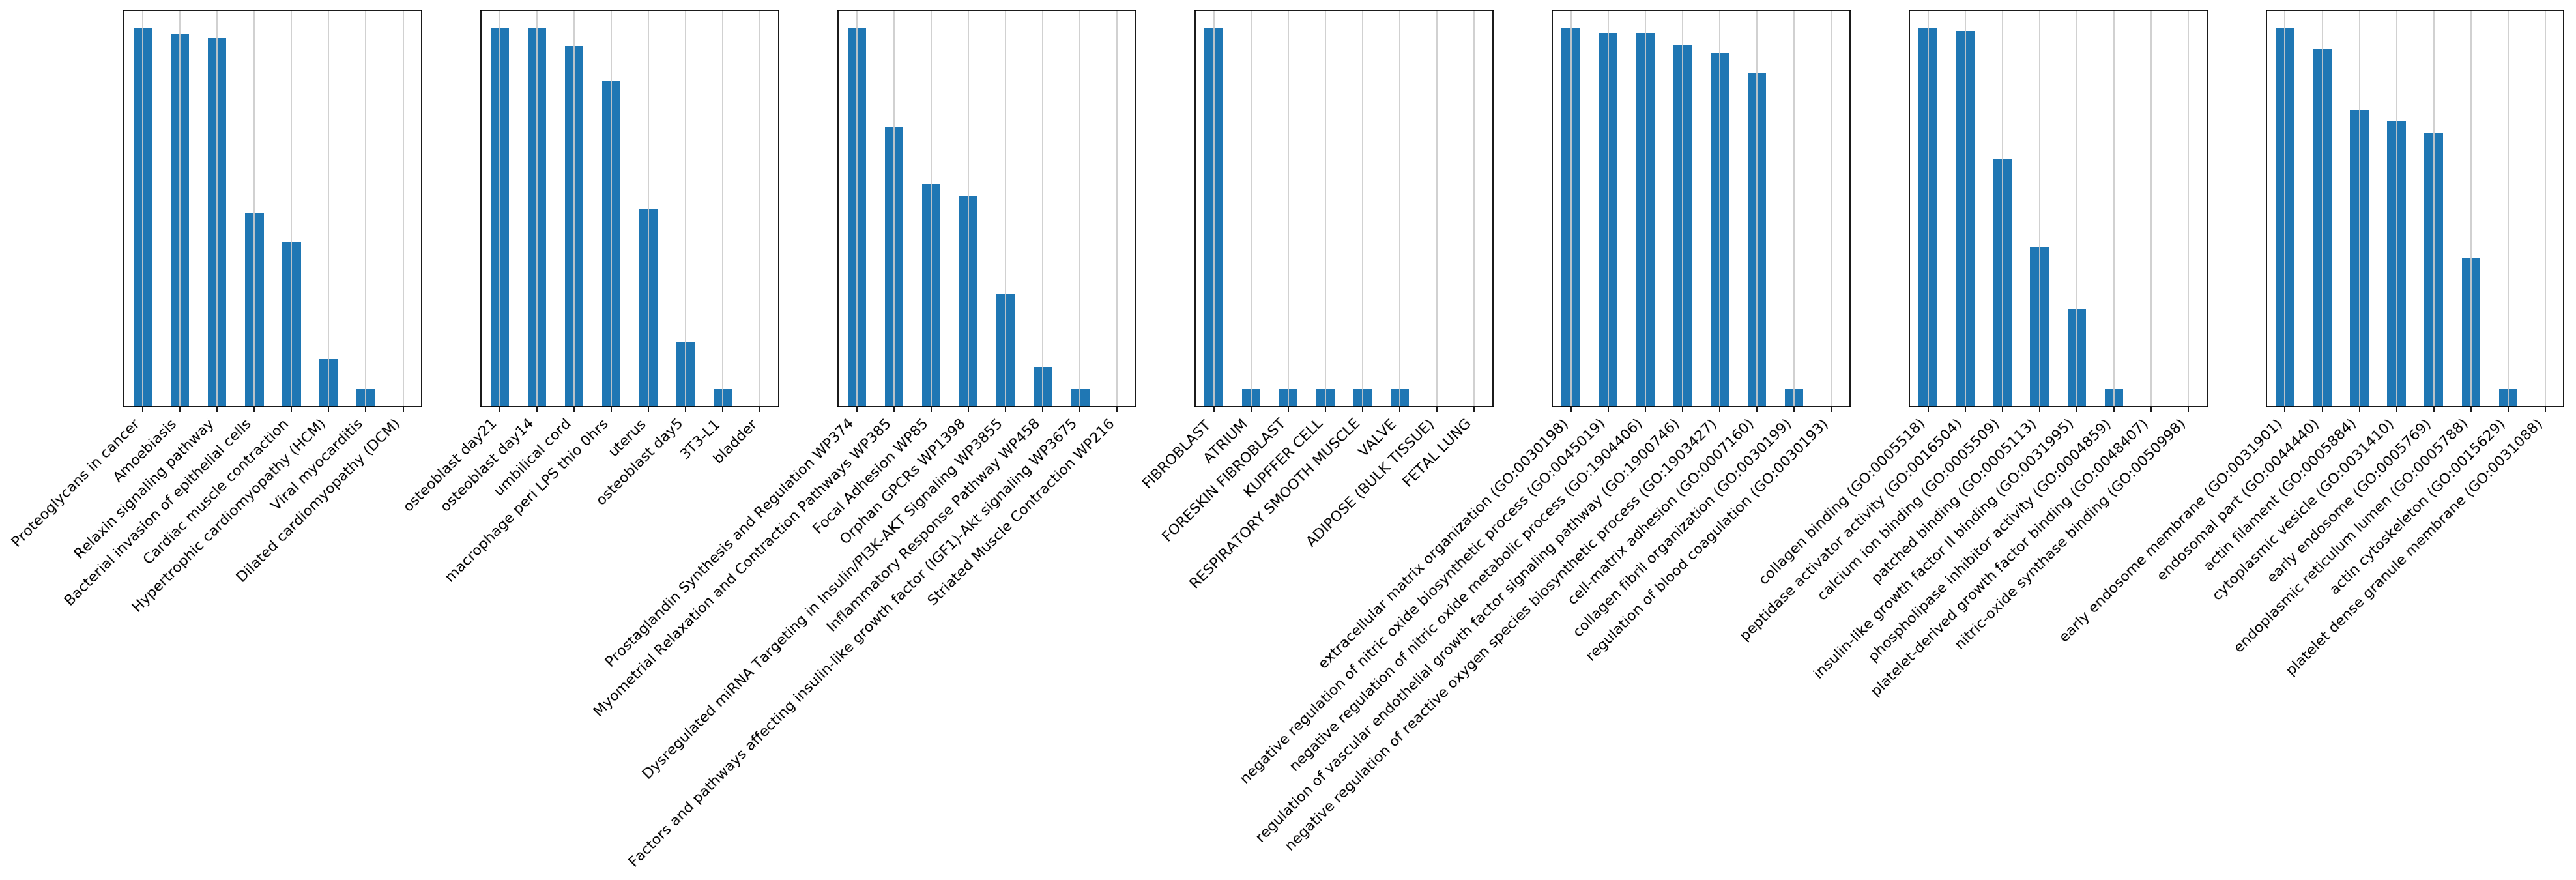

In [ ]:
gsea_dicts = dict()
for i in tqdm(range(11)):
    gsea_dicts[i] = dict()
    gsea_dicts[i]['enrichr'] = enrichr(list(data['adata_m'].uns['rank_genes_groups']['names'][str(i)][:25]), plot=True)
    gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error

In [50]:
gsea_dicts = {0: {'annotation': 'Hep (Chol+)'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'ECM (Mito)'}, 3: {'annotation': 'Hep (Gly)'}, 4: {'annotation': 'Ribo'}, 5: {'annotation': 'ECM (Coll)'}, 6: {'annotation': 'Hep (Chol++)'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}
# gsea_dicts = {0: {'annotation': 'Hep_1'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'MC38_1'}, 3: {'annotation': 'Hep_2'}, 4: {'annotation': 'MC38_2'}, 5: {'annotation': 'MC38_3'}, 6: {'annotation': 'Hep_3'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}

In [51]:
for i in range(11):
    print(str(i) + ': ' + gsea_dicts[i]['annotation'])

0: Hep (Chol+)
1: MPhage
2: ECM (Mito)
3: Hep (Gly)
4: Ribo
5: ECM (Coll)
6: Hep (Chol++)
7: T/NK
8: Kupffer
9: LSECs
10: B


In [52]:
ctdict = dict()
for i in range(11):
    ctdict[gsea_dicts[i]['annotation']] = [i]
    
liver1.obs['celltype'] = liver1.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        liver1.obs['celltype'].replace(r'^%s$' % str(clust), '10X_%s' % ct, regex=True, inplace=True)
liver1.obs['celltype'] = liver1.obs['celltype'].astype('category')

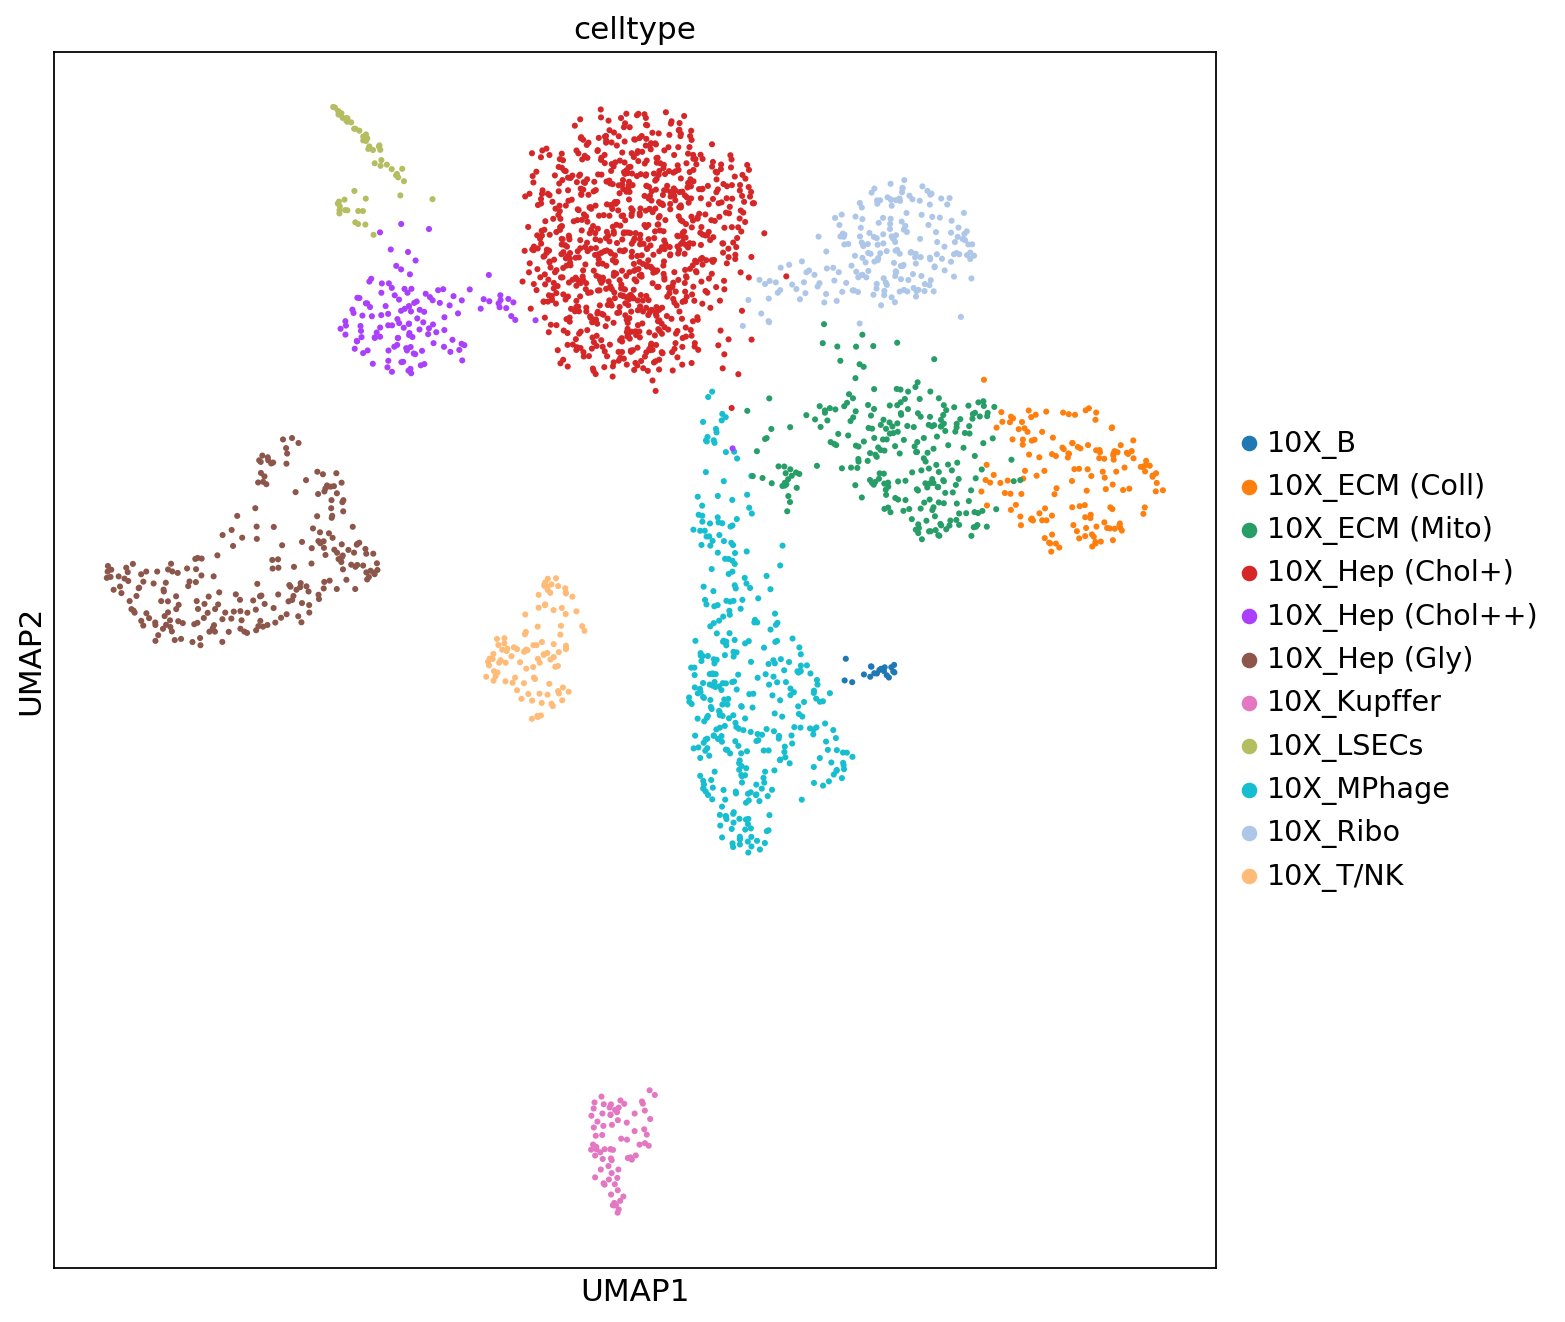

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.umap(liver1,color=['celltype'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/10x.umap.pdf')

In [54]:
ctdict = dict()
ctdict['Hep'] = [0, 3, 6]
ctdict['MC38'] = [2, 4, 5]
ctdict['Mphage'] = [1]
ctdict['B'] = [10]
ctdict['T/NK'] = [7]
ctdict['LSECs'] = [9]
ctdict['Kupffer'] = [8]
liver1.obs['celltype2'] = liver1.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        liver1.obs['celltype2'].replace(r'^%s$' % str(clust),'10X_%s' % ct,regex=True, inplace=True)
liver1.obs['celltype2'] = liver1.obs['celltype2'].astype('category')

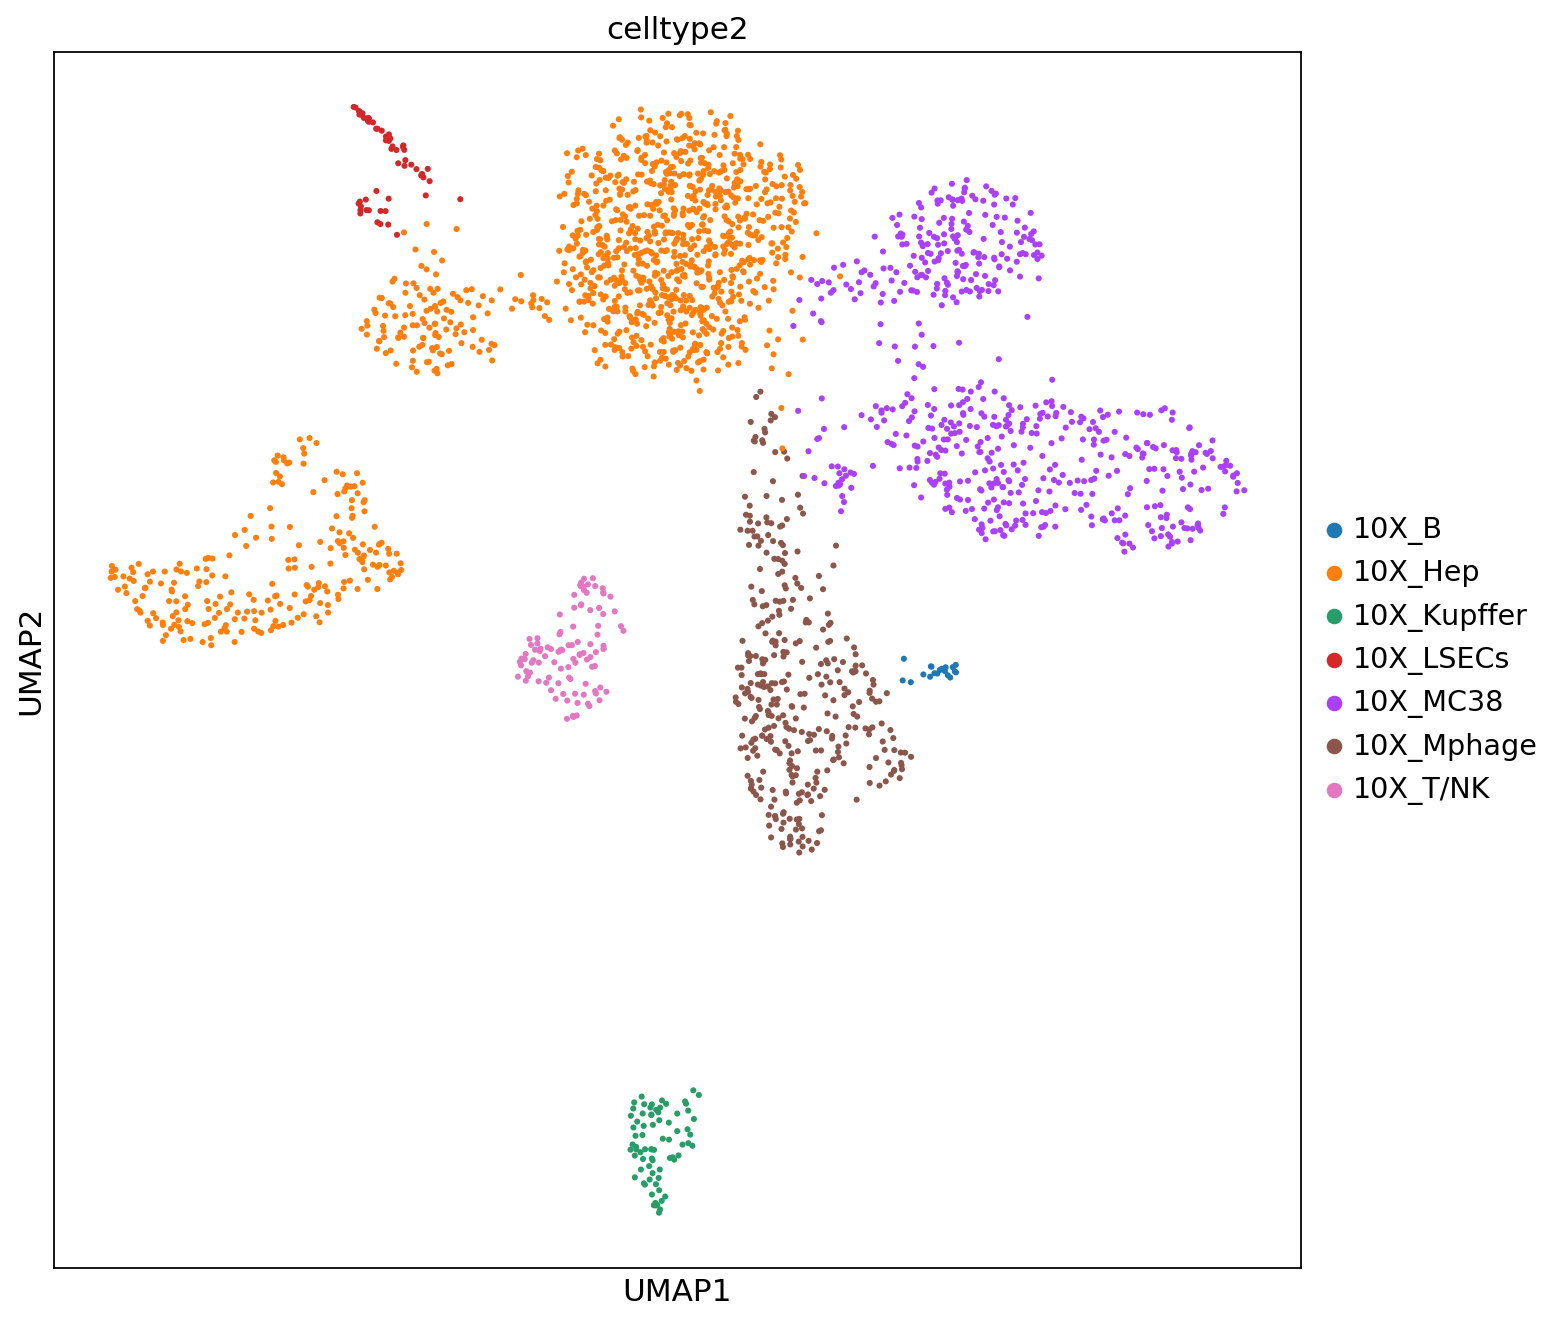

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.umap(liver1,color=['celltype2'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/10x.umap.pdf')

### Load in the XYZeq data

In [13]:
l20c1_prefix = prefix + 'xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/'
l20c1_raw = sc.read_h5ad(l20c1_prefix + 'adata.1.h5ad')
l20c1 = sc.read_h5ad(l20c1_prefix + 'adata.6.h5ad')

In [14]:
l20c1_h = l20c1[:,[i for i in l20c1.var_names if i.startswith('hg19_')]].copy()
l20c1_h = l20c1_h[l20c1_h.obs['celltype'] == 'Hek293t'].copy()

In [15]:
l20c1_m = l20c1[:,[i for i in l20c1.var_names if i.startswith('mm10_')]].copy()
l20c1_m = l20c1_m[l20c1_m.obs['celltype'] != 'Hek293t'].copy()

In [16]:
l20c1_m.var_names = [i[5:] for i in l20c1_m.var_names]

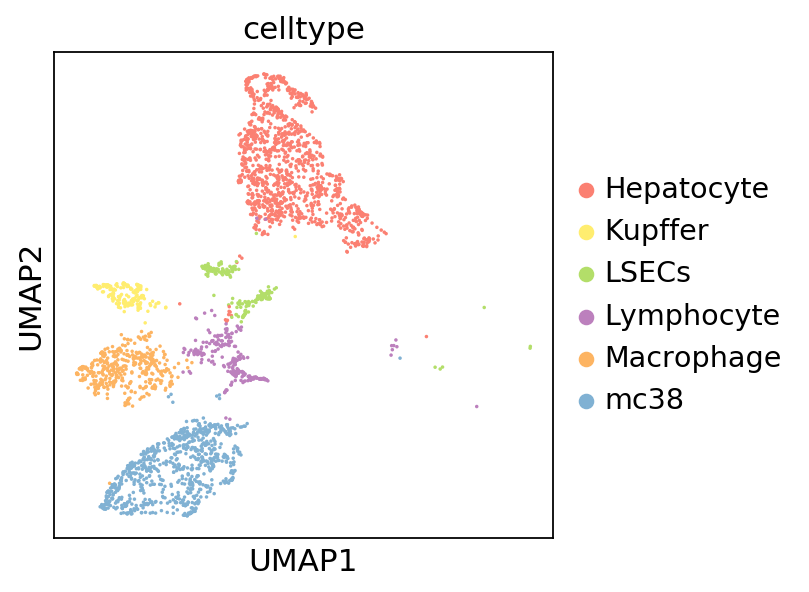

In [17]:
sc.pl.umap(l20c1_m,color=['celltype'], size=10)

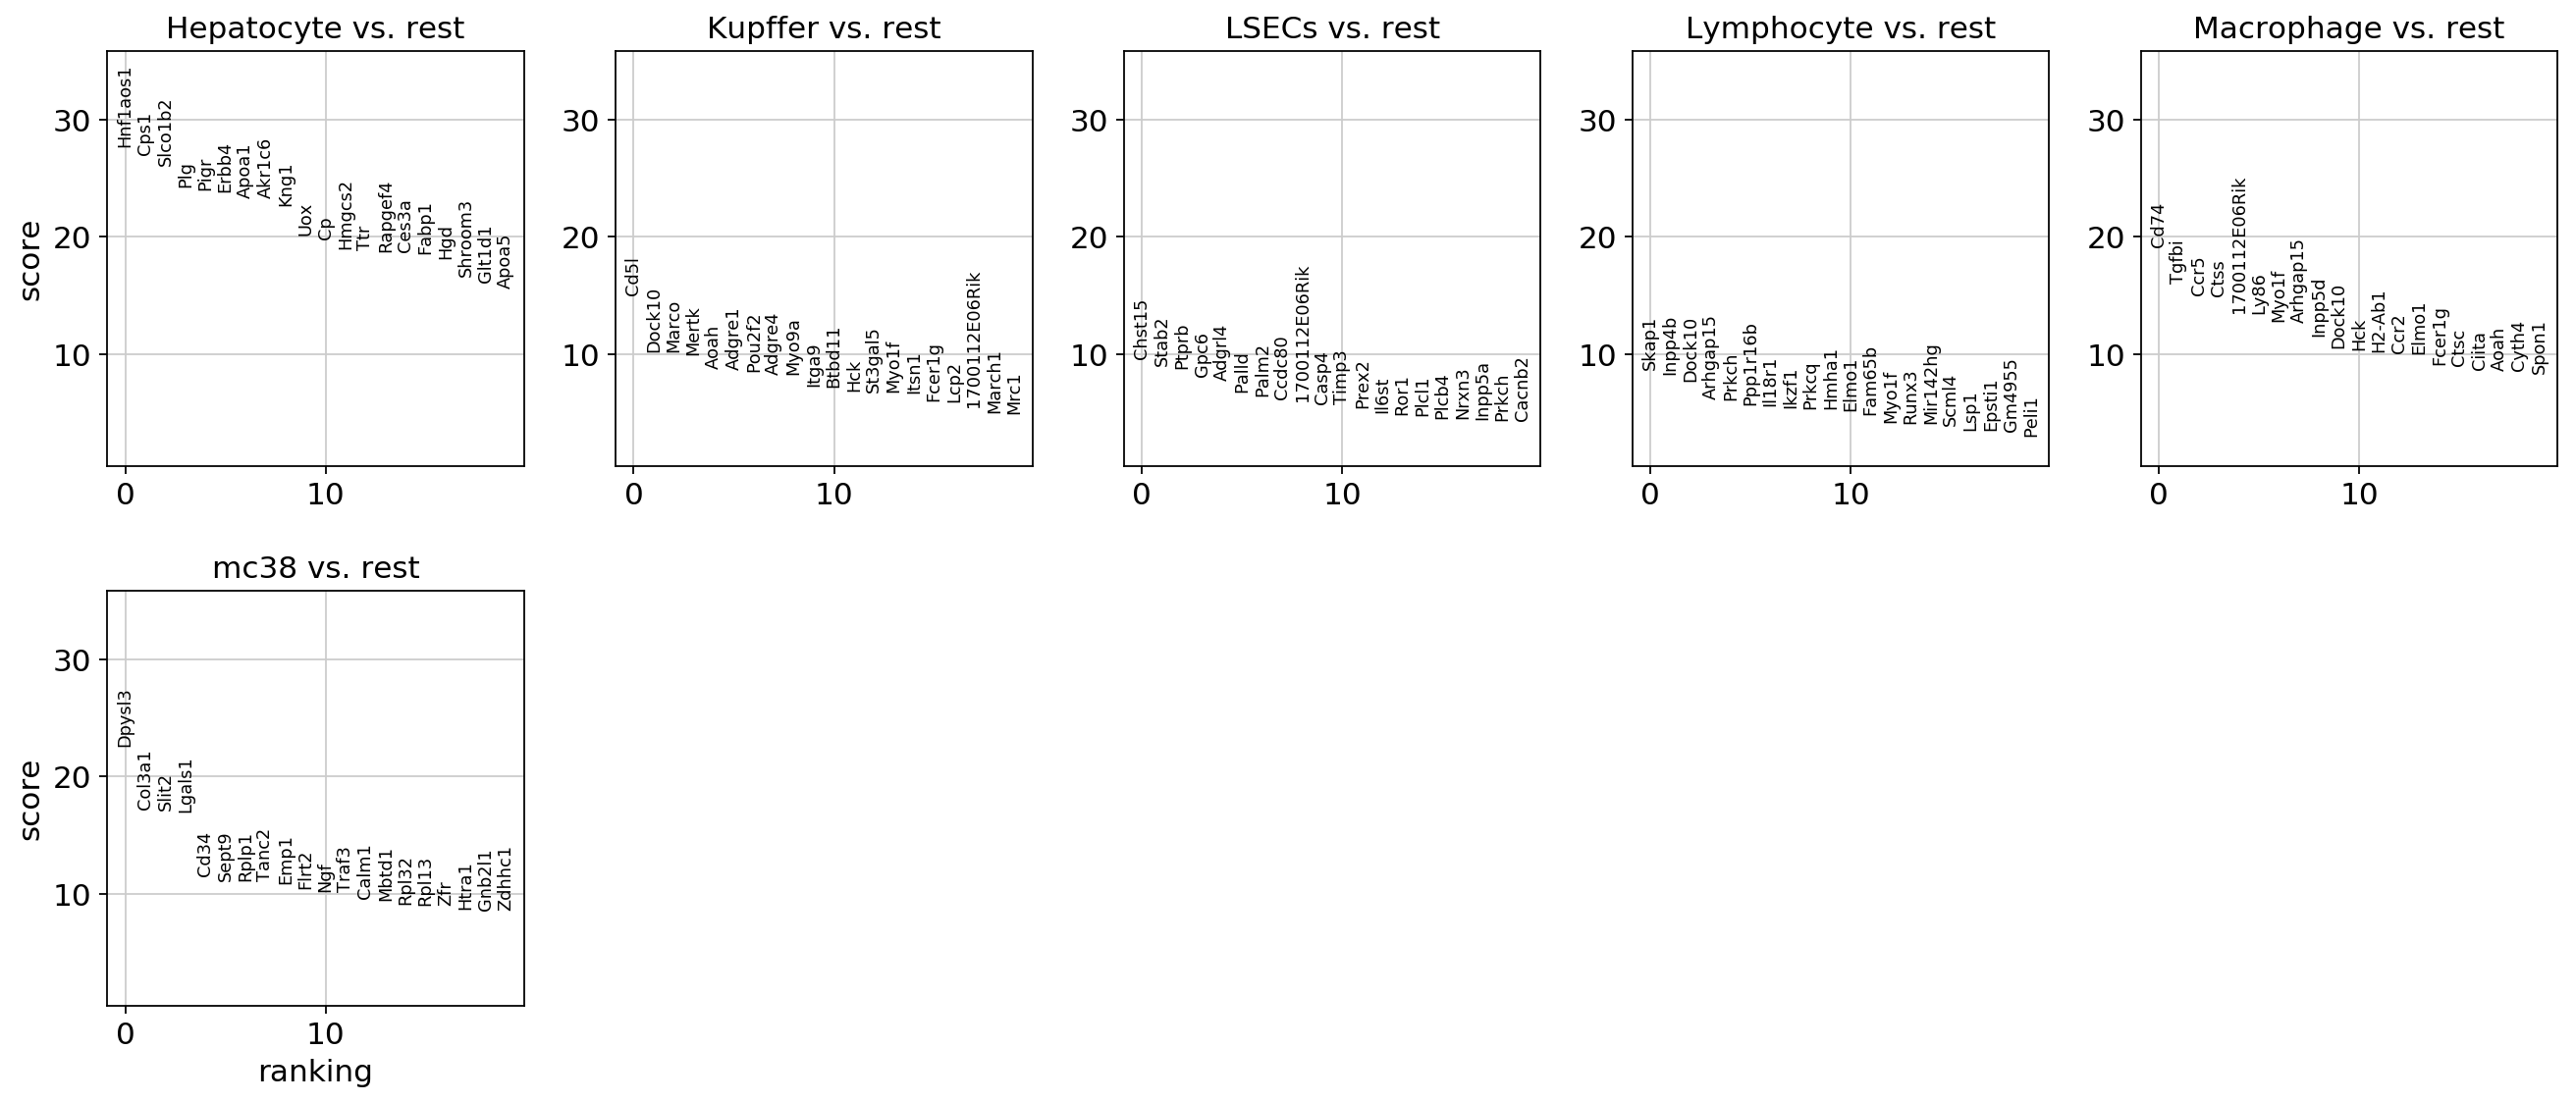

In [211]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1_m, groupby='celltype', use_raw=False)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(l20c1_m, ncols=5)
sc.settings.verbosity = 3

In [18]:
ctdict = dict()
ctdict['XYZ_Hep'] = ['Hepatocyte']
ctdict['XYZ_Mphage'] = ['Macrophage']
ctdict['XYZ_Kupffer'] = ['Kupffer']
ctdict['XYZ_LSECs'] = ['LSECs']
ctdict['XYZ_Lymphocyte'] = ['Lymphocyte']
ctdict['XYZ_MC38'] = ['mc38']
l20c1_m.obs['celltype2'] = l20c1_m.obs['celltype']
for ct in ctdict:
    for clust in ctdict[ct]:
        l20c1_m.obs['celltype2'].replace(r'^%s$' % str(clust),ct, regex=True, inplace=True)
l20c1_m.obs['celltype2'] = l20c1_m.obs['celltype2'].astype('category')

In [19]:
l20c1_m.uns['celltype2_colors'] =  ['#FB8072', '#FFED6F', '#B3DE69', '#BC80BD', '#FDB462', '#80B1D3'] # got from Derek's Slack Message

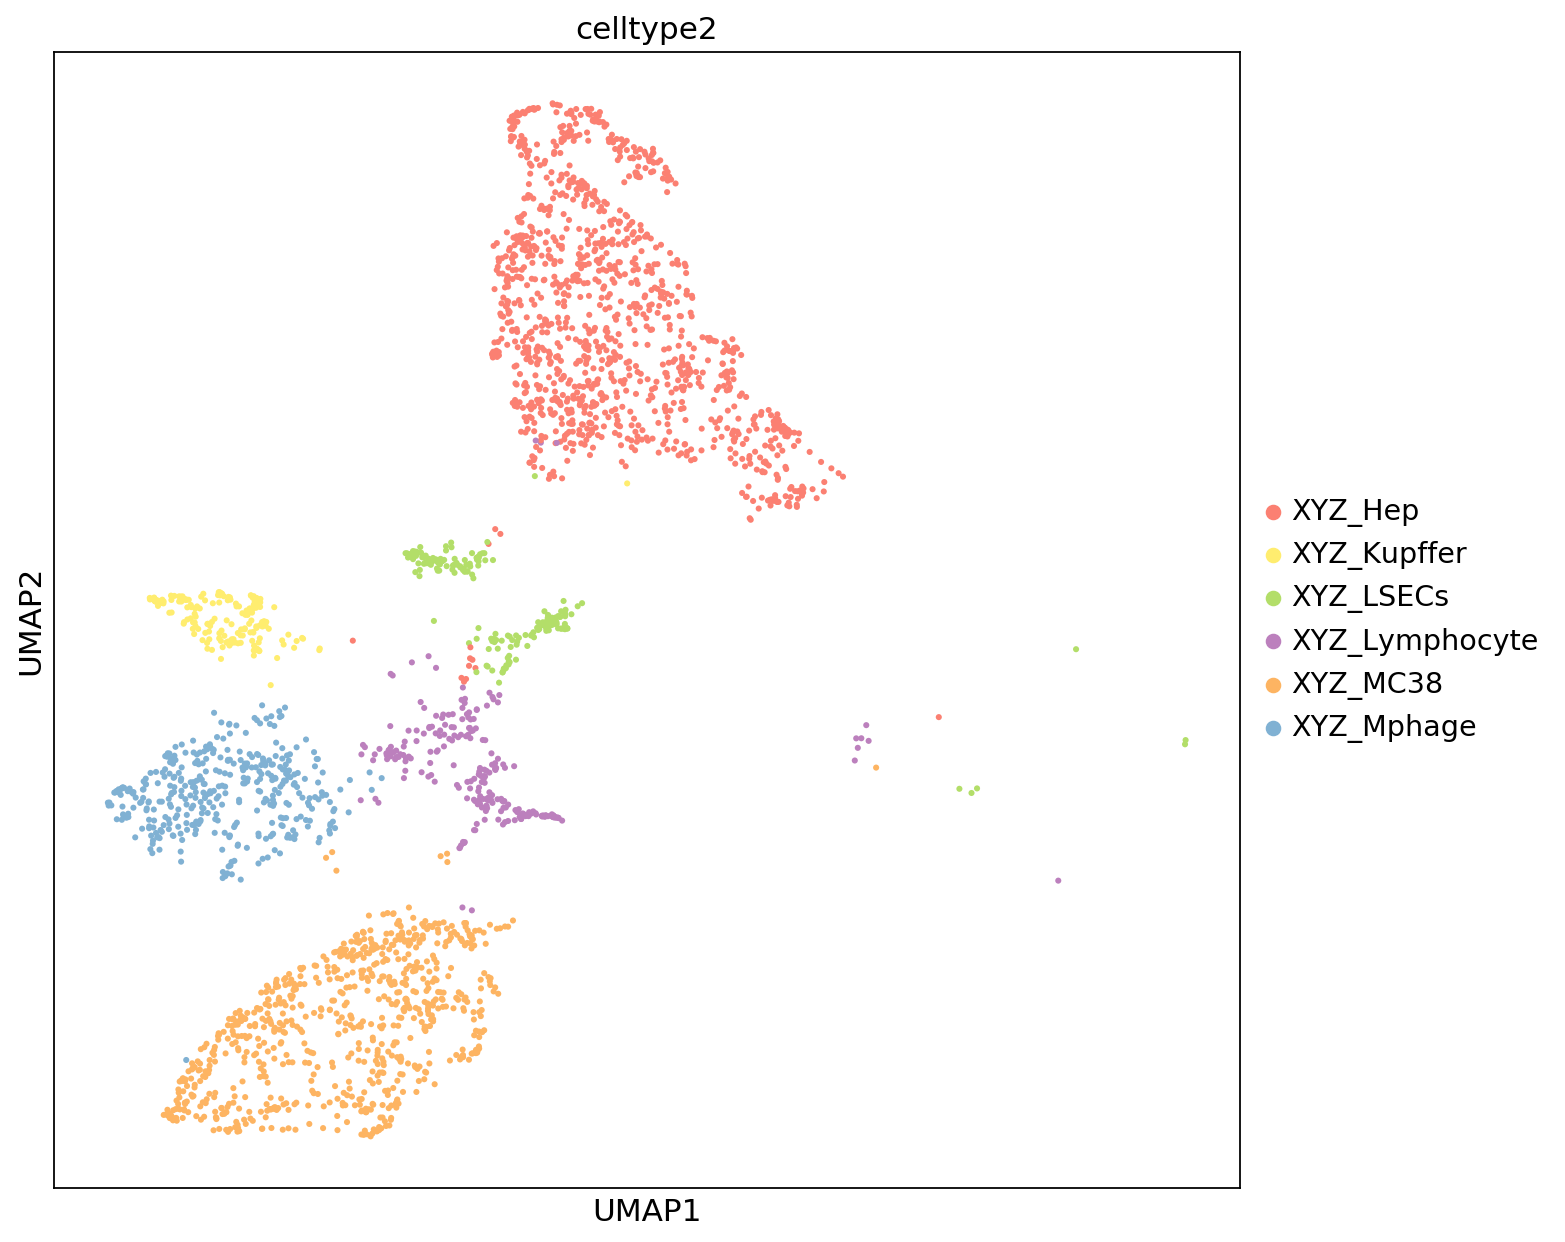

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
sc.pl.umap(l20c1_m,color=['celltype2'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
# plt.savefig(prefix + '10x/20191102/figures/10x.umap.pdf')

### Violin Plots

First off, get the n_genes parameter in the `obs`.

In [108]:
l20c1_raw.shape

(4788, 50241)

In [109]:
sc.pp.filter_cells(liver1_raw, min_genes=0)
sc.pp.filter_cells(l20c1_raw, min_genes=0)

I would like to plot a split violin, since it's cleaner and would save space.

In [135]:
dfs_umis = list()
for adata, method in zip([l20c1_raw, liver1_raw],['XYZeq', '10x']):
    umis = np.log10(adata.obs['n_counts'].values)
    dfs_umis.append(pd.DataFrame(zip(umis,
                                     [method]*len(adata)),
                                 columns = ['UMIs', 'Method']))

In [136]:
dfs_genes = list()
for adata, method in zip([l20c1_raw, liver1_raw],['XYZeq', '10x']):
    genes = np.log10(adata.obs['n_genes'].values)
    dfs_genes.append(pd.DataFrame(zip(genes,
                                      [method]*len(adata)),
                                  columns = ['Genes', 'Method']))

In [137]:
violin_df_umis = pd.concat(dfs_umis)
violin_df_umis.index = range(len(violin_df_umis))

In [138]:
violin_df_genes = pd.concat(dfs_genes)
violin_df_genes.index = range(len(violin_df_genes))

In [139]:
# this is some hacky way to make the single variable show up split, see https://stackoverflow.com/questions/33745746/split-violinplot-in-seaborn-with-hue-parameter
violin_df_umis['all'] = "" 
violin_df_genes['all'] = ""

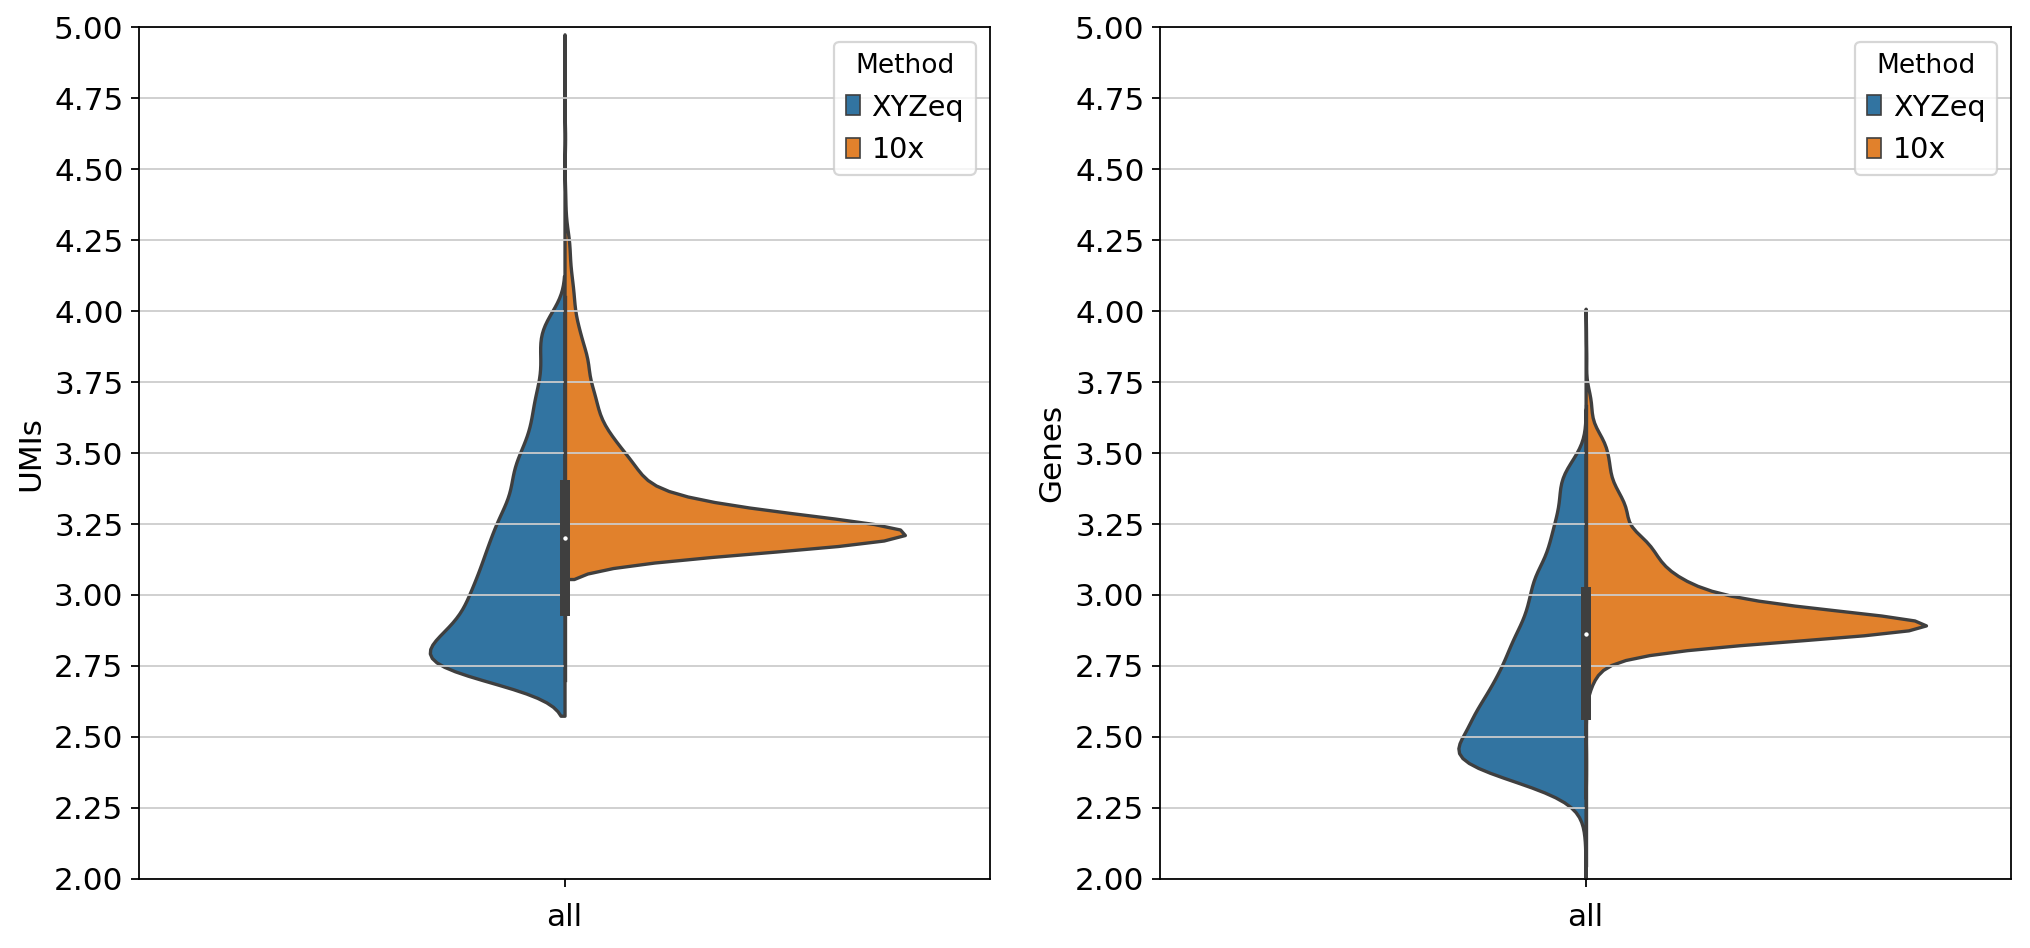

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.violinplot(x="all", y="UMIs", data=violin_df_umis, hue='Method', split=True, ax=ax[0]);
ax[0].set_ylim(2,5);
ax[0].set_yticks(np.arange(2,5.25,0.25));
# ax[0].set_yscale('log')
sns.violinplot(x="all", y="Genes", data=violin_df_genes, hue='Method', split=True, ax=ax[1]);
ax[1].set_ylim(2,5);
ax[1].set_yticks(np.arange(2,5.25,0.25));
# ax[1].set_yscale('log')
plt.savefig(prefix + '10x/20191102/figures/umi.gene.violins.pdf')

### Cell Type Correlations

Code taken from https://github.com/yelabucsf/lupus_1M_cells_clean/blob/master/figure6_flare/Figure6Flare.V6.ipynb

In [215]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """A function go get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata        - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                   an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                   genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                   'louvain_r1' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

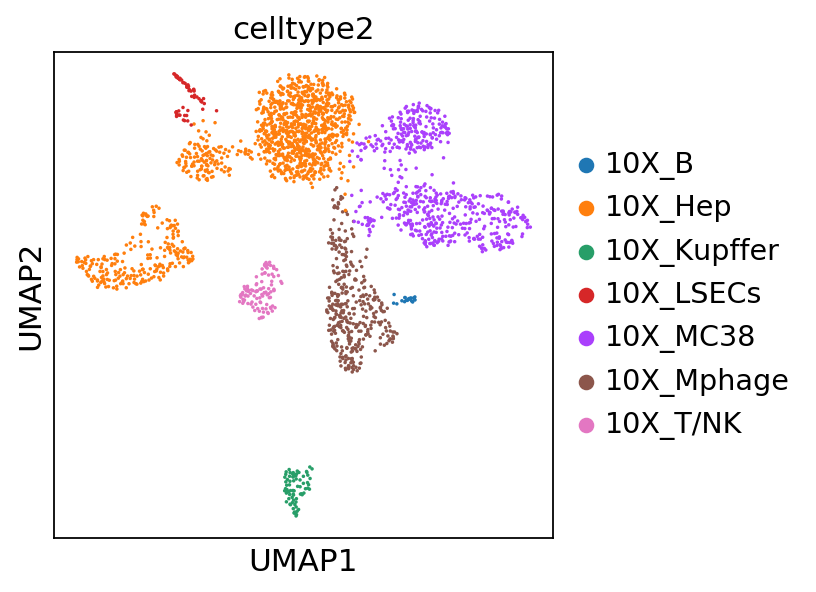

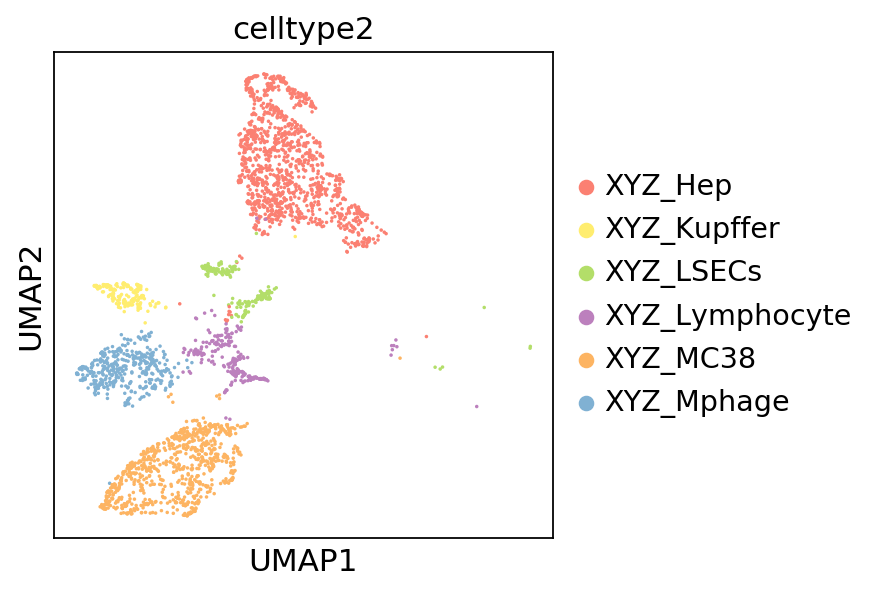

In [216]:
sc.pl.umap(liver1,color=['celltype2'], size=10)
sc.pl.umap(l20c1_m,color=['celltype2'], size=10)

In [217]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1_m, groupby='celltype2')
sc.tl.rank_genes_groups(liver1, groupby='celltype2')
warnings.filterwarnings('default')
sc.settings.verbosity = 4

In [218]:
cts = liver1.obs['celltype2'].unique()
genes = np.concatenate([liver1.uns['rank_genes_groups']['names'][ct][:100] for ct in cts])
genes = np.unique(genes)
genes = np.intersect1d(genes, l20c1_m.var_names.values)

In [219]:
marker_dictionary = pd.DataFrame({"all": genes})

In [220]:
l20c1_m_unscaled = sc.read_h5ad(l20c1_prefix + 'adata.4.h5ad')

In [221]:
l20c1_m_unscaled = l20c1_m_unscaled[l20c1_m.obs_names].copy()

In [222]:
liver1_unscaled.obs['celltype2'] = liver1.obs['celltype2'].values
l20c1_m_unscaled.obs['celltype2'] = l20c1_m.obs['celltype2'].values

In [223]:
l20c1_m_unscaled.var_names = [i[5:] for i in l20c1_m_unscaled.var_names]

In [224]:
marker_exp_10x = marker_gene_expression(liver1_unscaled, marker_dictionary, partition_key="celltype2")

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [225]:
marker_exp_XYZeq = marker_gene_expression(l20c1_m_unscaled, marker_dictionary, partition_key="celltype2")

In [226]:
exp_result = pd.concat([marker_exp_10x, marker_exp_XYZeq], axis=1, join='inner')

In [230]:
exp_result = exp_result[['10X_Hep', '10X_LSECs', '10X_MC38', '10X_Kupffer', '10X_Mphage', '10X_T/NK', '10X_B', 'XYZ_Hep', 'XYZ_LSECs', 'XYZ_MC38', 'XYZ_Kupffer', 'XYZ_Mphage', 'XYZ_Lymphocyte']]

In [231]:
exp_result

10X_Hep  10X_LSECs  10X_MC38  10X_Kupffer  10X_Mphage  \
4932438A13Rik -0.034374   0.972221 -0.166033     0.161361    0.020704   
Adgre4        -0.014150  -0.149686 -0.096809     1.902658   -0.108097   
Apbb1ip       -0.138856  -0.290841 -0.122637     1.092703    0.446317   
Apoa1          0.582650  -0.347366 -0.630991    -0.446106   -0.672584   
Apoa2          0.547010  -0.414550 -0.599779    -0.403047   -0.622038   
...                 ...        ...       ...          ...         ...   
Uox            0.295849  -0.173257 -0.307565    -0.043551   -0.380447   
Upf3b         -0.040690   0.581500 -0.086223    -0.086063    0.076001   
Vtn            0.391594  -0.178121 -0.389623    -0.466816   -0.445142   
Wfdc21         0.292808  -0.265908 -0.313197    -0.020176   -0.291232   
Znrf1         -0.028735   1.307725 -0.051678    -0.046620   -0.104177   

               10X_T/NK     10X_B   XYZ_Hep  XYZ_LSECs  XYZ_MC38  XYZ_Kupffer  \
4932438A13Rik  0.630803  0.347953 -0.020324   0.074117 -0.005597    -0.098547   
Adgre4        -0.149686 -0.149686 -0.133774   0.019344 -0.123769     1.757766   
Apbb1ip        0.154260  0.318707 -0.186443  -0.072489 -0.033485     0.230274   
Apoa1         -0.305247 -0.613070  0.537837   0.014836 -0.508639     0.125865   
Apoa2         -0.292024 -0.288245  0.377775  -0.033648 -0.315733    -0.027255   
...                 ...       ...       ...        ...       ...          ...   
Uox           -0.278673 -0.054518  0.494612  -0.273483 -0.340829    -0.238663   
Upf3b          0.219620  1.464234  0.066309  -0.038508 -0.008166    -0.110279   
Vtn           -0.339121 -0.443470  0.298665  -0.023140 -0.231845    -0.146731   
Wfdc21        -0.410024 -0.481823  0.206829  -0.050589 -0.154187    -0.111503   
Znrf1          0.367956 -0.107611 -0.027657   0.137521  0.064391    -0.085794   

               XYZ_Mphage  XYZ_Lymphocyte  
4932438A13Rik   -0.006783        0.143844  
Adgre4          -0.152453       -0.010926  
Apbb1ip          0.444150        0.191670  
Apoa1           -0.536742       -0.276400  
Apoa2           -0.351591       -0.246872  
...                   ...             ...  
Uox             -0.366563       -0.370989  
Upf3b           -0.047988       -0.112097  
Vtn             -0.251645       -0.205090  
Wfdc21          -0.167997       -0.137009  
Znrf1           -0.081912        0.018682  

[107 rows x 13 columns]

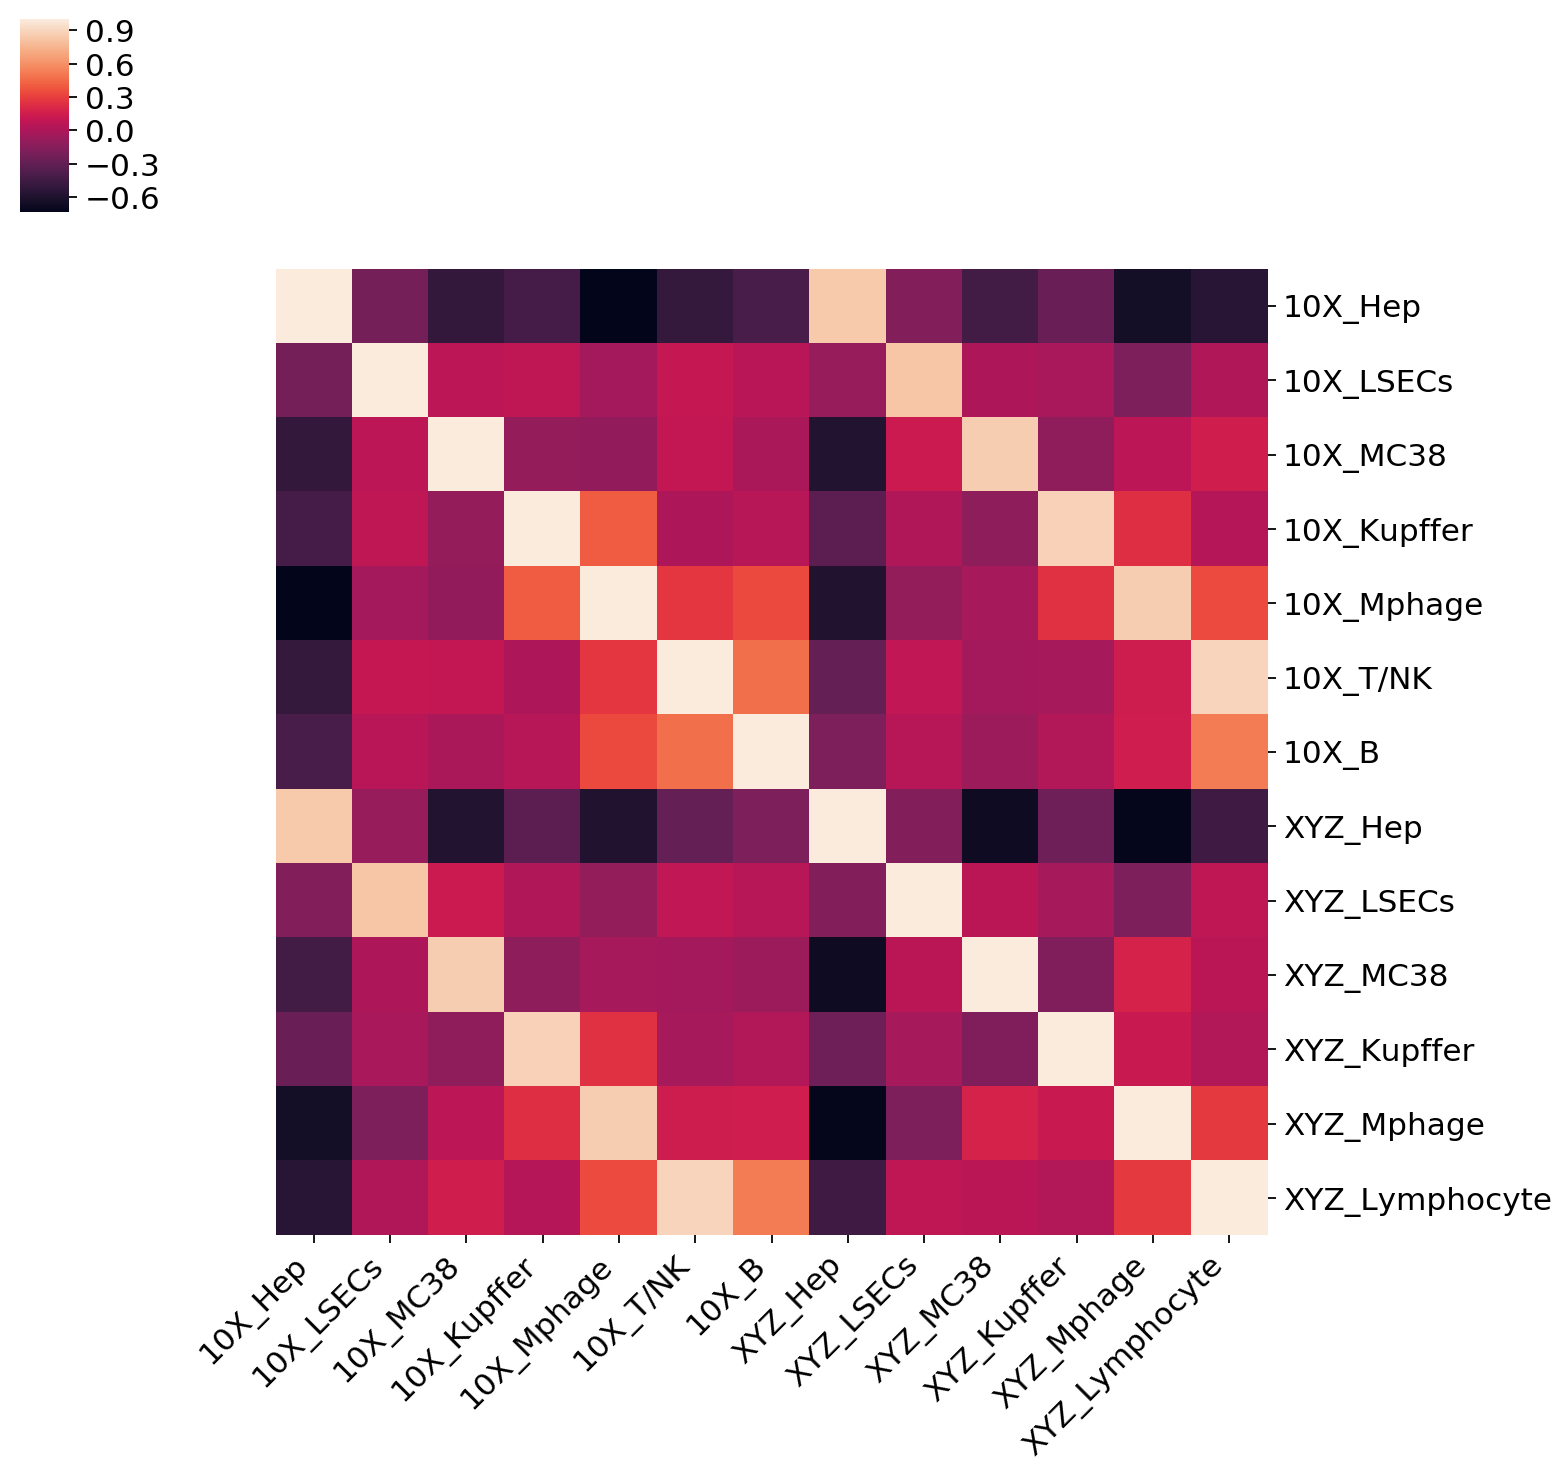

In [233]:
exp_corr = exp_result.corr()
exp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# fig, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.clustermap(exp_corr, yticklabels=True, xticklabels=True, row_cluster=False, col_cluster=False);
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right');
g.savefig(prefix + '10x/20191102/figures/10x.L20C1.ct.heatmap.pdf')

# Merge the Datasets

I need to combine the 10x data with L20C1. I'll merge the raw counts after filtering, and then run Harmony, followed by dimensionality reduction and clustering. 

Concatenate on the inner join of genes, and get rid of the batch key.

In [56]:
liver1_for_concat = sc.read_h5ad(prefix + '10x/20191102/Liver1_raw_feature_bc_matrix.stable.h5')

In [57]:
l20c1_for_concat = sc.read_h5ad(l20c1_prefix + 'adata.1.h5ad')

In [58]:
print(liver1_for_concat.shape)
print(l20c1_for_concat.shape)

(6794880, 28692)
(4788, 50241)


In [59]:
liver1_for_concat = liver1_for_concat[liver1.obs_names].copy()

In [60]:
l20c1_for_concat = l20c1_for_concat[l20c1_m.obs_names].copy()

l20c1_for_concat = l20c1_for_concat[:,[i for i in l20c1_for_concat.var_names if i.startswith('mm10_')]].copy()
l20c1_for_concat.var_names
l20c1_for_concat.var_names = [i[5:] for i in l20c1_for_concat.var_names]

In [61]:
print(liver1_for_concat.shape)
print(l20c1_for_concat.shape)

(2475, 28692)
(2978, 22374)


In [62]:
concat = liver1_for_concat.concatenate(l20c1_for_concat, join='inner')

In [63]:
concat.shape

(5453, 22374)

In [64]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

### USING HARMONY:

Write to file so I can run Harmony in a separate notebook.

In [245]:
concat.write_h5ad(prefix + '10x/20191102/concat.liver1.L20C1.derek.h5ad')

... storing 'cell_call' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


Normalize per cell and log1p. I do this in Harmony separately using Seurat.

In [65]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Read back in the embeddings from Harmony.

In [66]:
harmony = pd.read_csv(prefix + '10x/20191102/harmony.embeddings.liver1.L20C1.derek.all.csv')
concat.obsm['X_pca'] = harmony.values

In [67]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=5,n_pcs=50) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


### End using Harmony

### USING BBKNN:

In [224]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


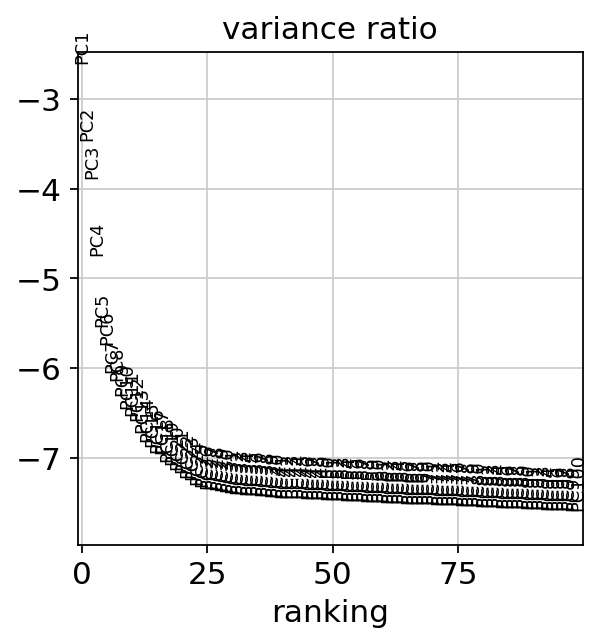

In [225]:
warnings.filterwarnings('ignore')
sc.pp.pca(concat,n_comps=100)
sc.pl.pca_variance_ratio(concat,log=True, n_pcs=100)
warnings.filterwarnings('default')

In [226]:
bbknn_adata = bbknn.bbknn(concat, neighbors_within_batch=5, n_pcs=0, copy=True)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


### End using BBKNN

Remap the batches to make them more descriptive.

In [68]:
concat.obs['batch'] = concat.obs['batch'].map({'0': '10x', '1':'XYZeq'})

In [69]:
sc.tl.umap(concat, spread=3)

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [70]:
sc.tl.leiden(concat,resolution=0.2)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_call' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


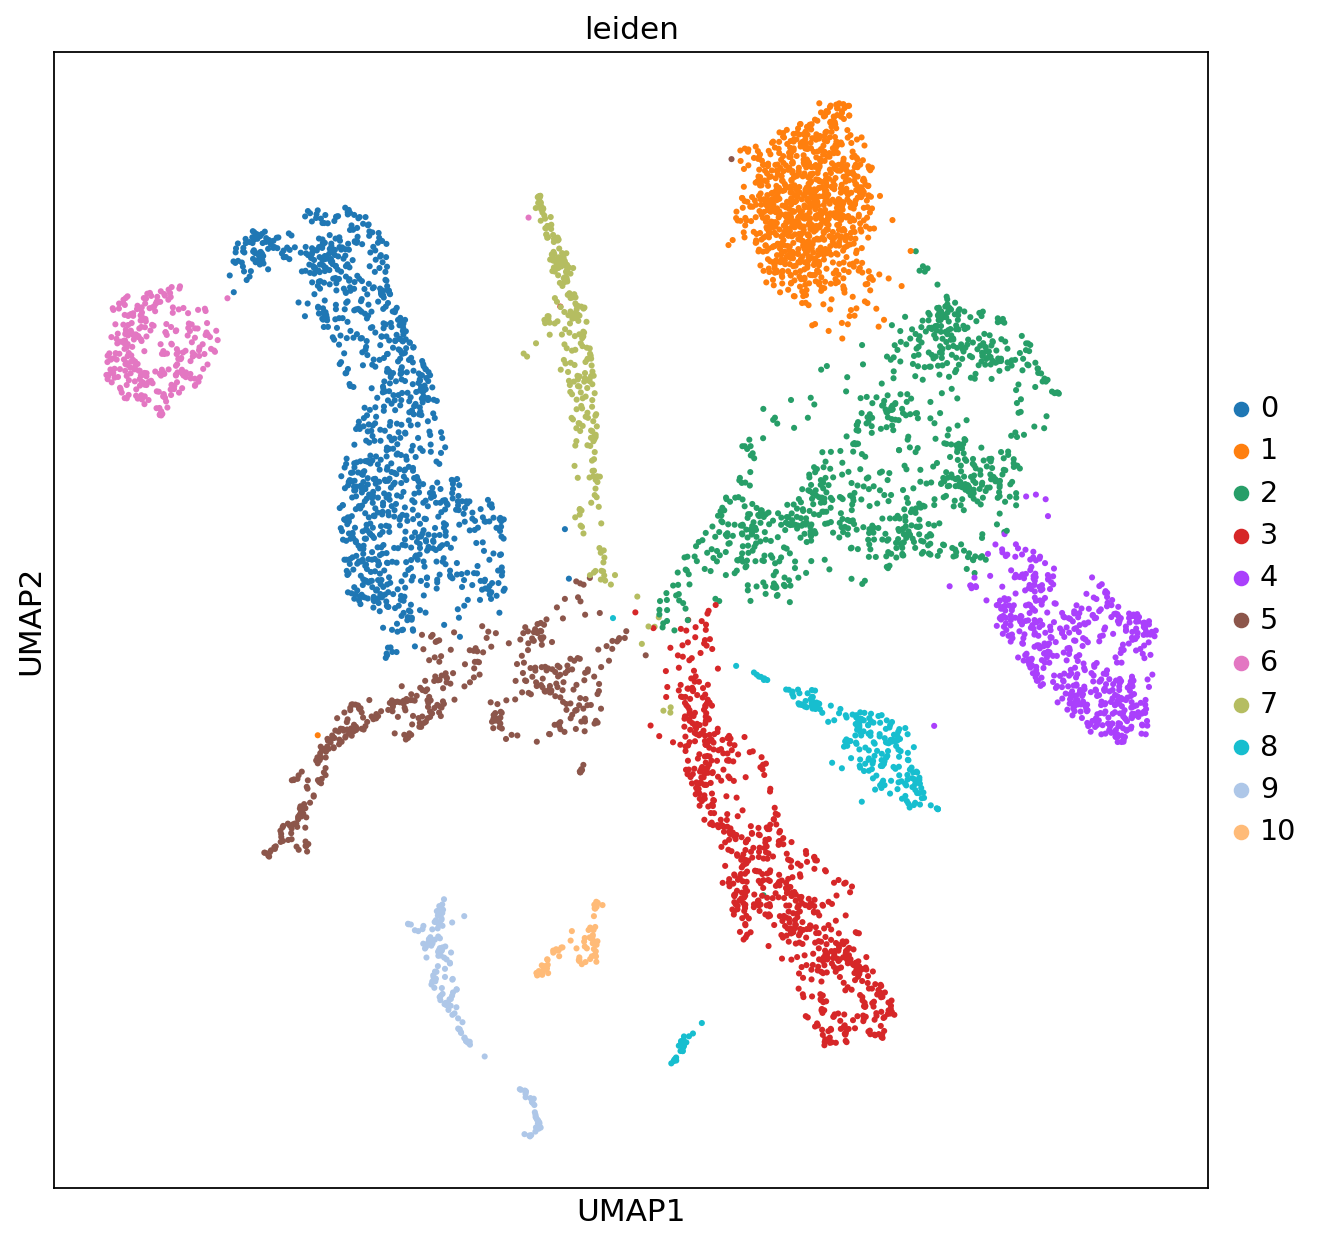

In [71]:
fig, ax = plt.subplots(1,1,figsize=(8.5,8))
sc.pl.umap(concat,color=['leiden'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.leiden.pdf')

In [72]:
batches = concat.obs['batch'].unique() # get a list of the batches
# make a new column in the `.obs` for each batch that is of dtype `int` and that just takes on values of 0 and 1 so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    concat.obs['batch_%s' % batch] = (concat.obs['batch'] == batch).astype(int)

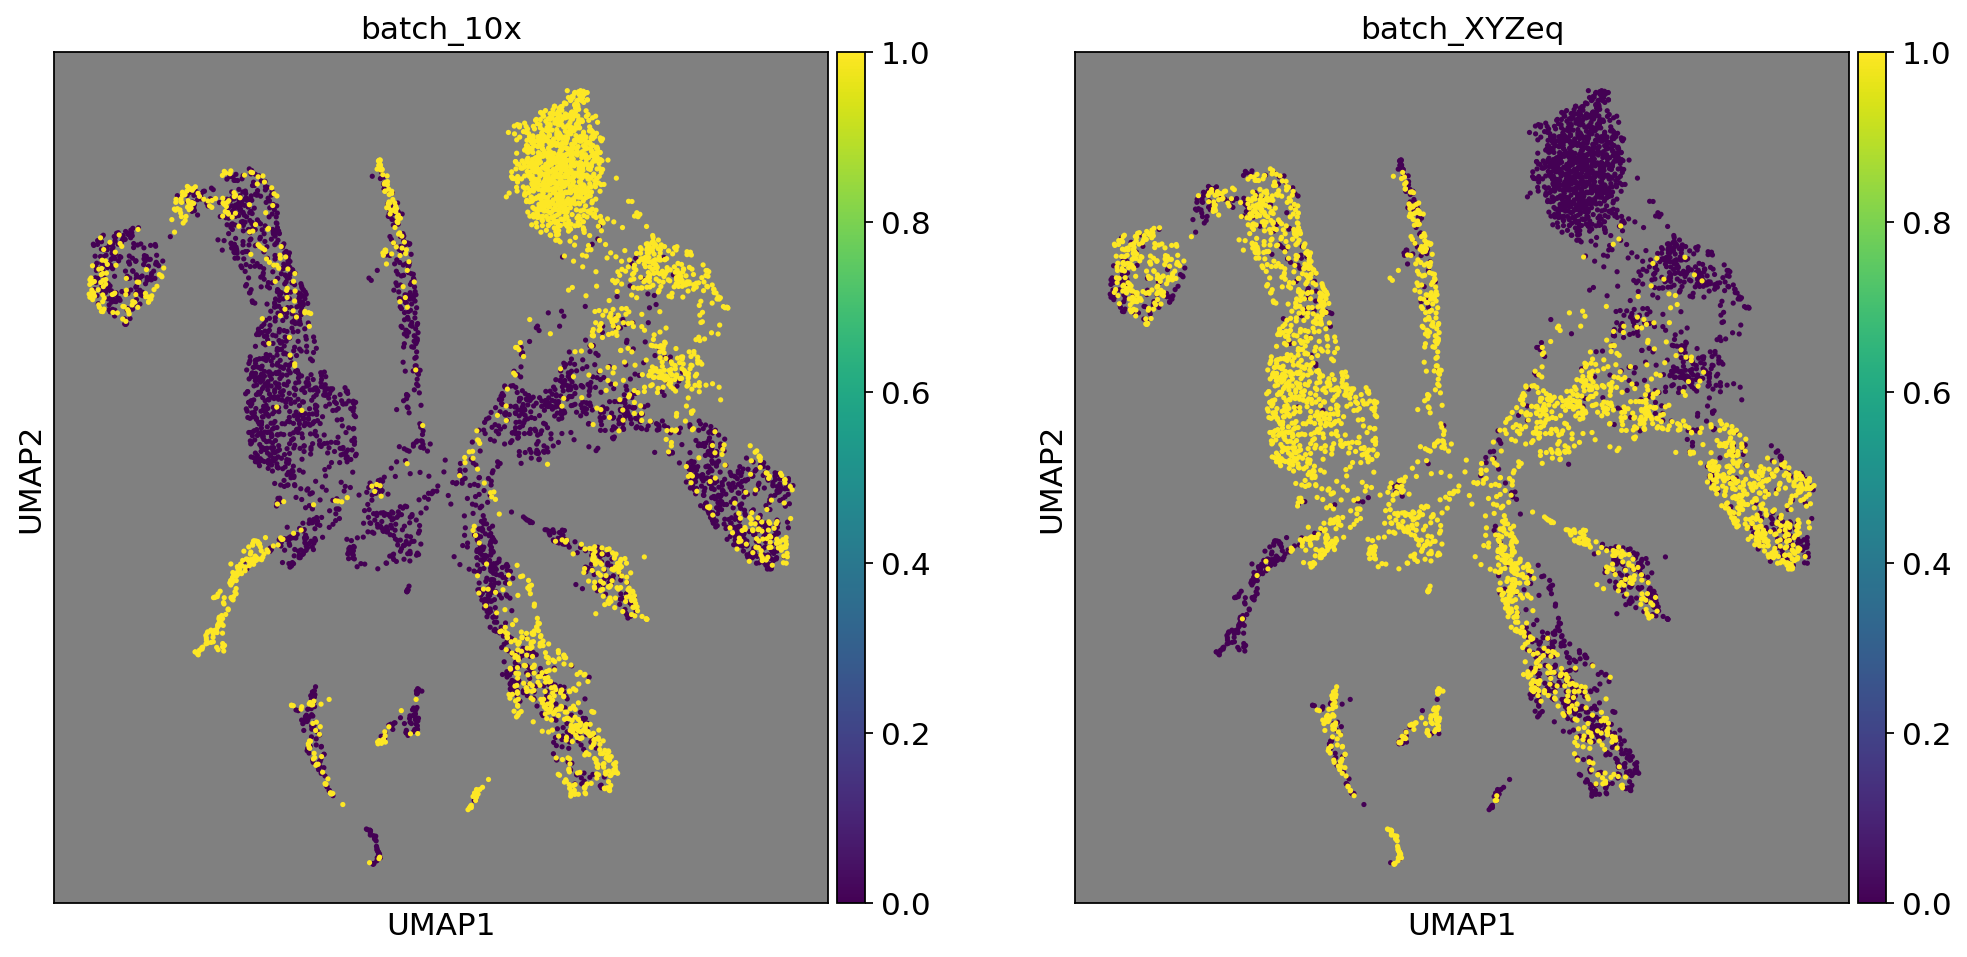

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch, ax in zip(batches, np.ravel(ax)):
    ax.set_facecolor('gray')
    sc.pl.umap(concat, color=['batch_%s' % batch], ax=ax, sort_order=True, show=False, return_fig=False)
plt.savefig(prefix + '10x/20191102/figures/concat.umap.batch.separate.overlay.pdf')

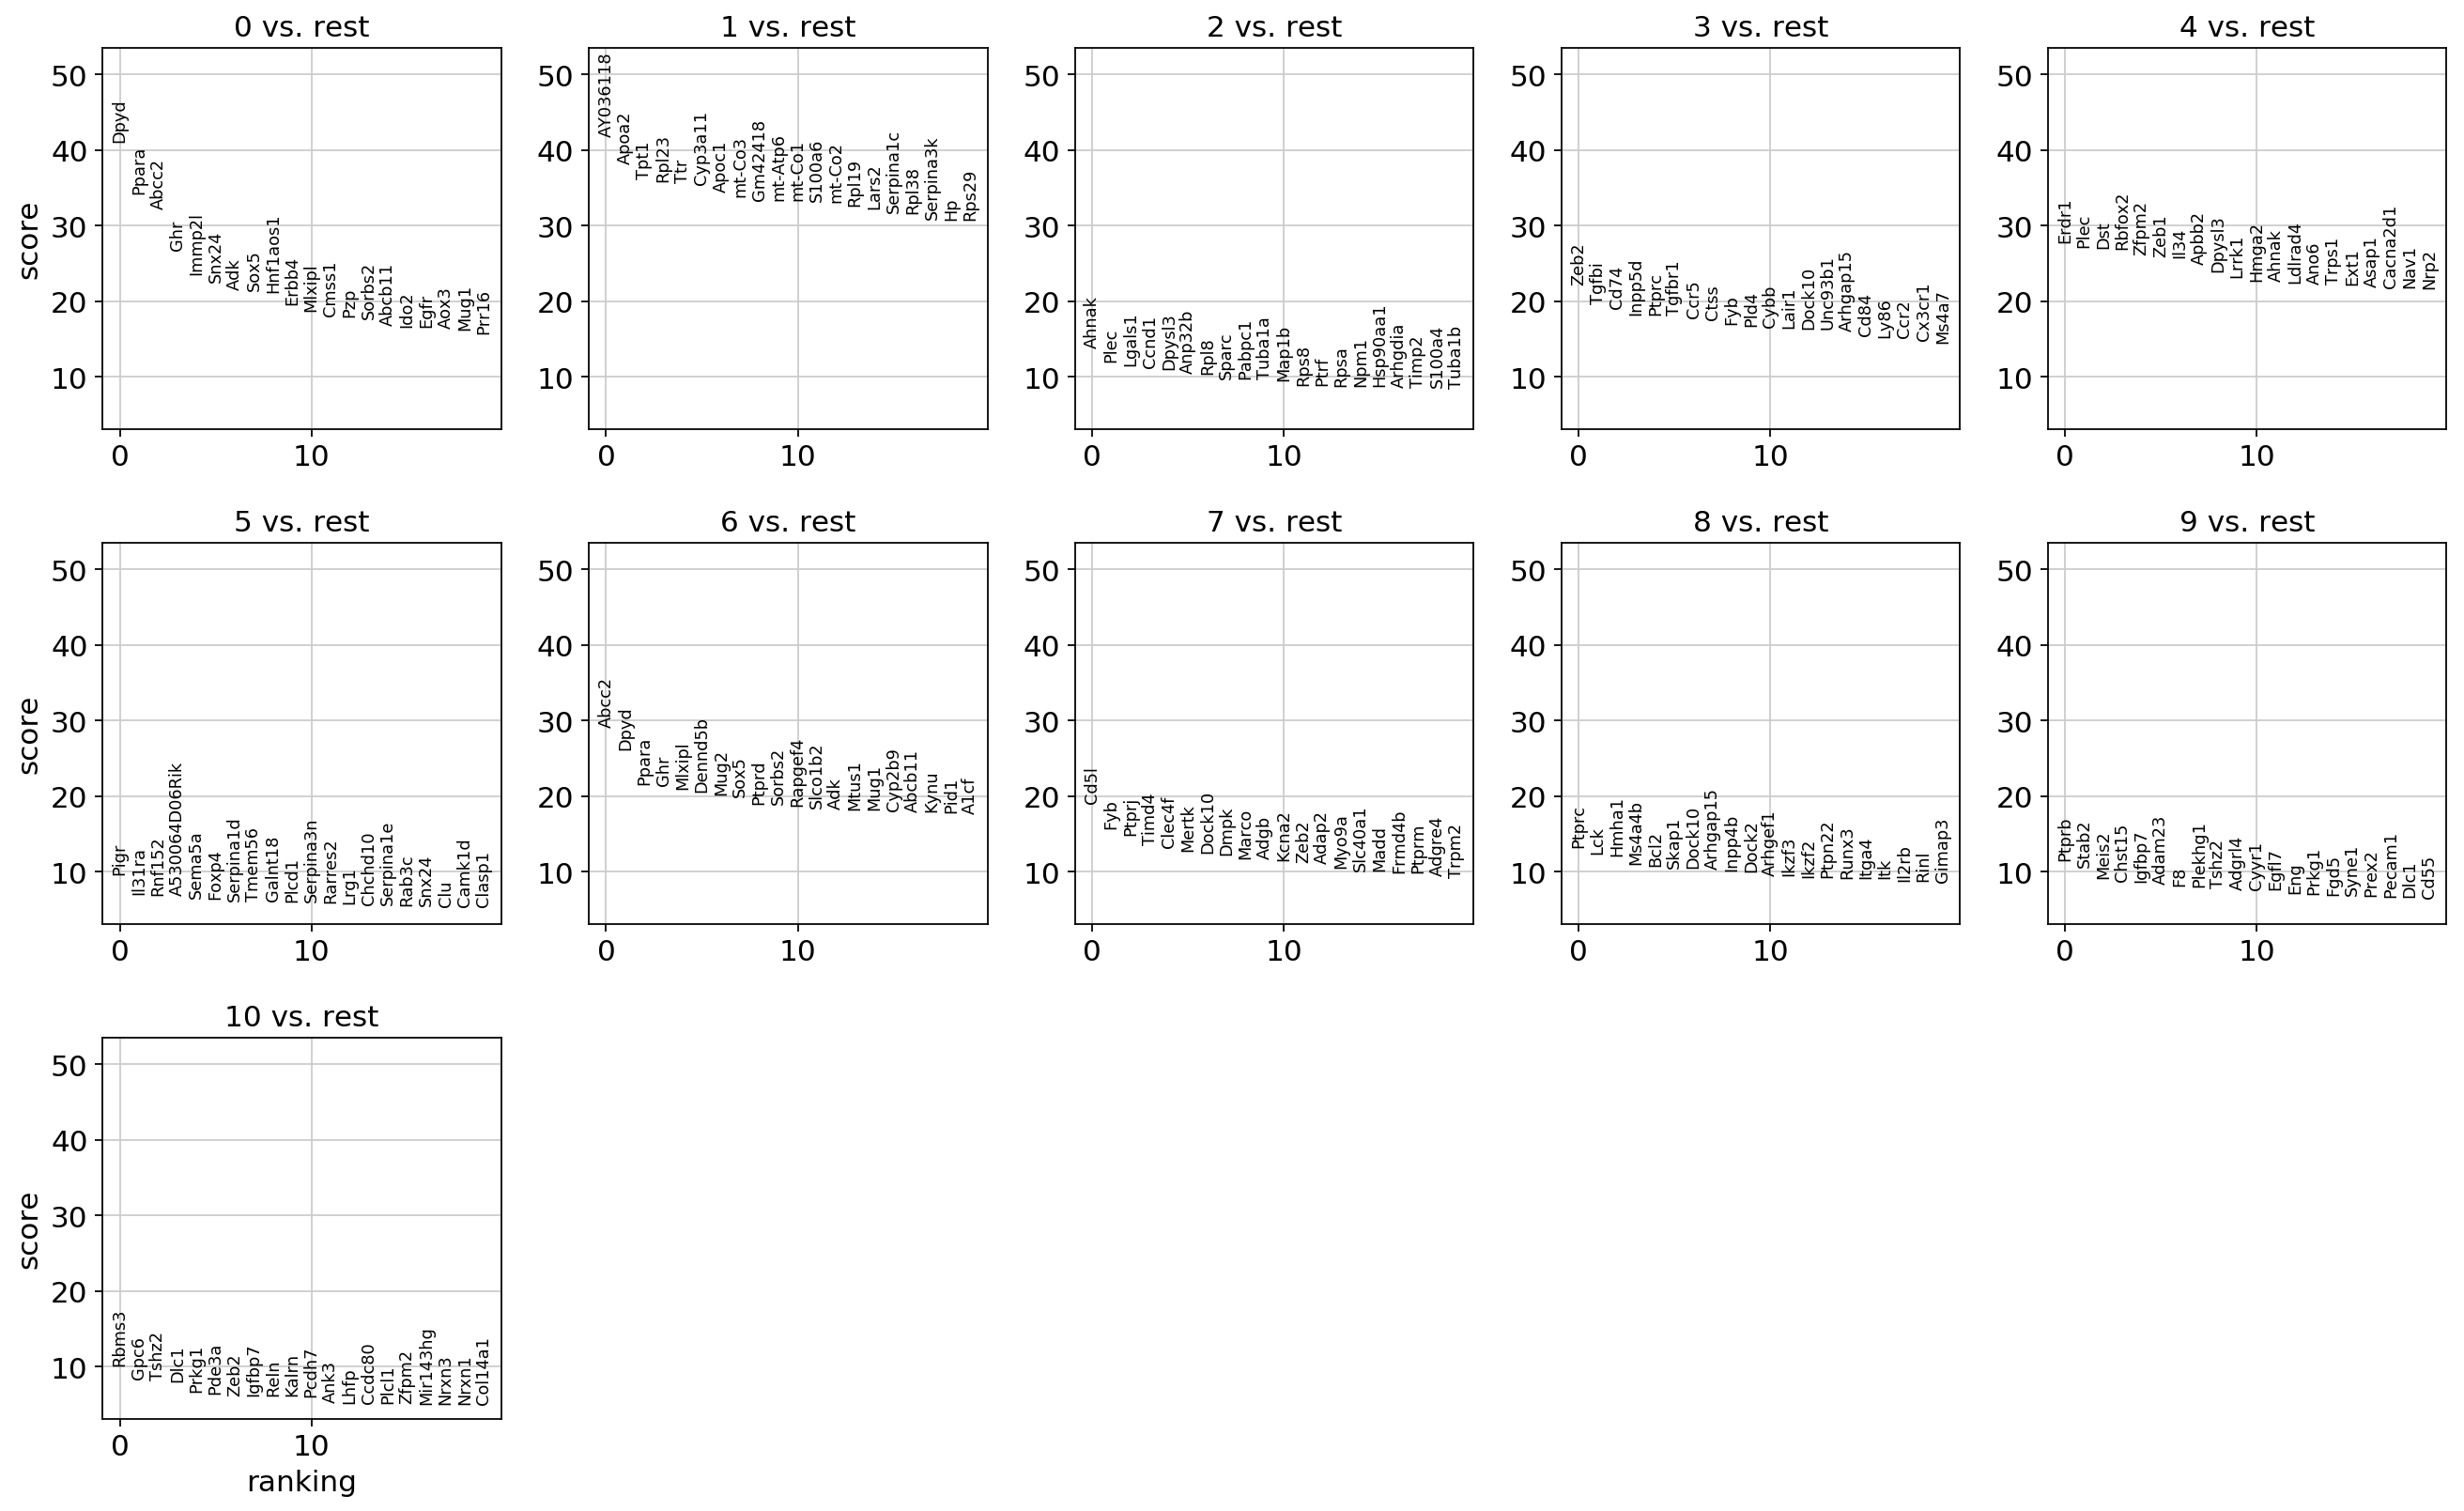

In [74]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

In [75]:
# gsea_dicts = dict()
# for i in tqdm(range(11)):
#     gsea_dicts[i] = dict()
#     gsea_dicts[i]['enrichr'] = enrichr(list(concat.uns['rank_genes_groups']['names'][str(i)][:25]), plot=True)
#     gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error

In [76]:
# gsea_dicts = {0: {'annotation': 'Hep (Chol+)'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'ECM (Mito)'}, 3: {'annotation': 'Hep (Gly)'}, 4: {'annotation': 'Ribo'}, 5: {'annotation': 'ECM (Coll)'}, 6: {'annotation': 'Hep (Chol++)'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}
# gsea_dicts = {0: {'annotation': 'Hep_1'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'MC38_1'}, 3: {'annotation': 'Hep_2'}, 4: {'annotation': 'MC38_2'}, 5: {'annotation': 'MC38_3'}, 6: {'annotation': 'Hep_3'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}

In [77]:
# for i in range(11):
#     print(str(i) + ': ' + gsea_dicts[i]['annotation'])

In [78]:
ctdict = dict()
ctdict['Hep'] = [0, 1, 5, 6]
ctdict['MC38'] = [2, 4]
ctdict['Macrophage'] = [3]
ctdict['Kupffer'] = [7]
ctdict['Lymphocyte'] = [8]
ctdict['LSEC'] = [9]
ctdict['Stellate'] = [10]
concat.obs['celltype'] = concat.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        concat.obs['celltype'].replace(r'^%s$' % str(clust),ct, regex=True, inplace=True)
concat.obs['celltype'] = concat.obs['celltype'].astype('category')

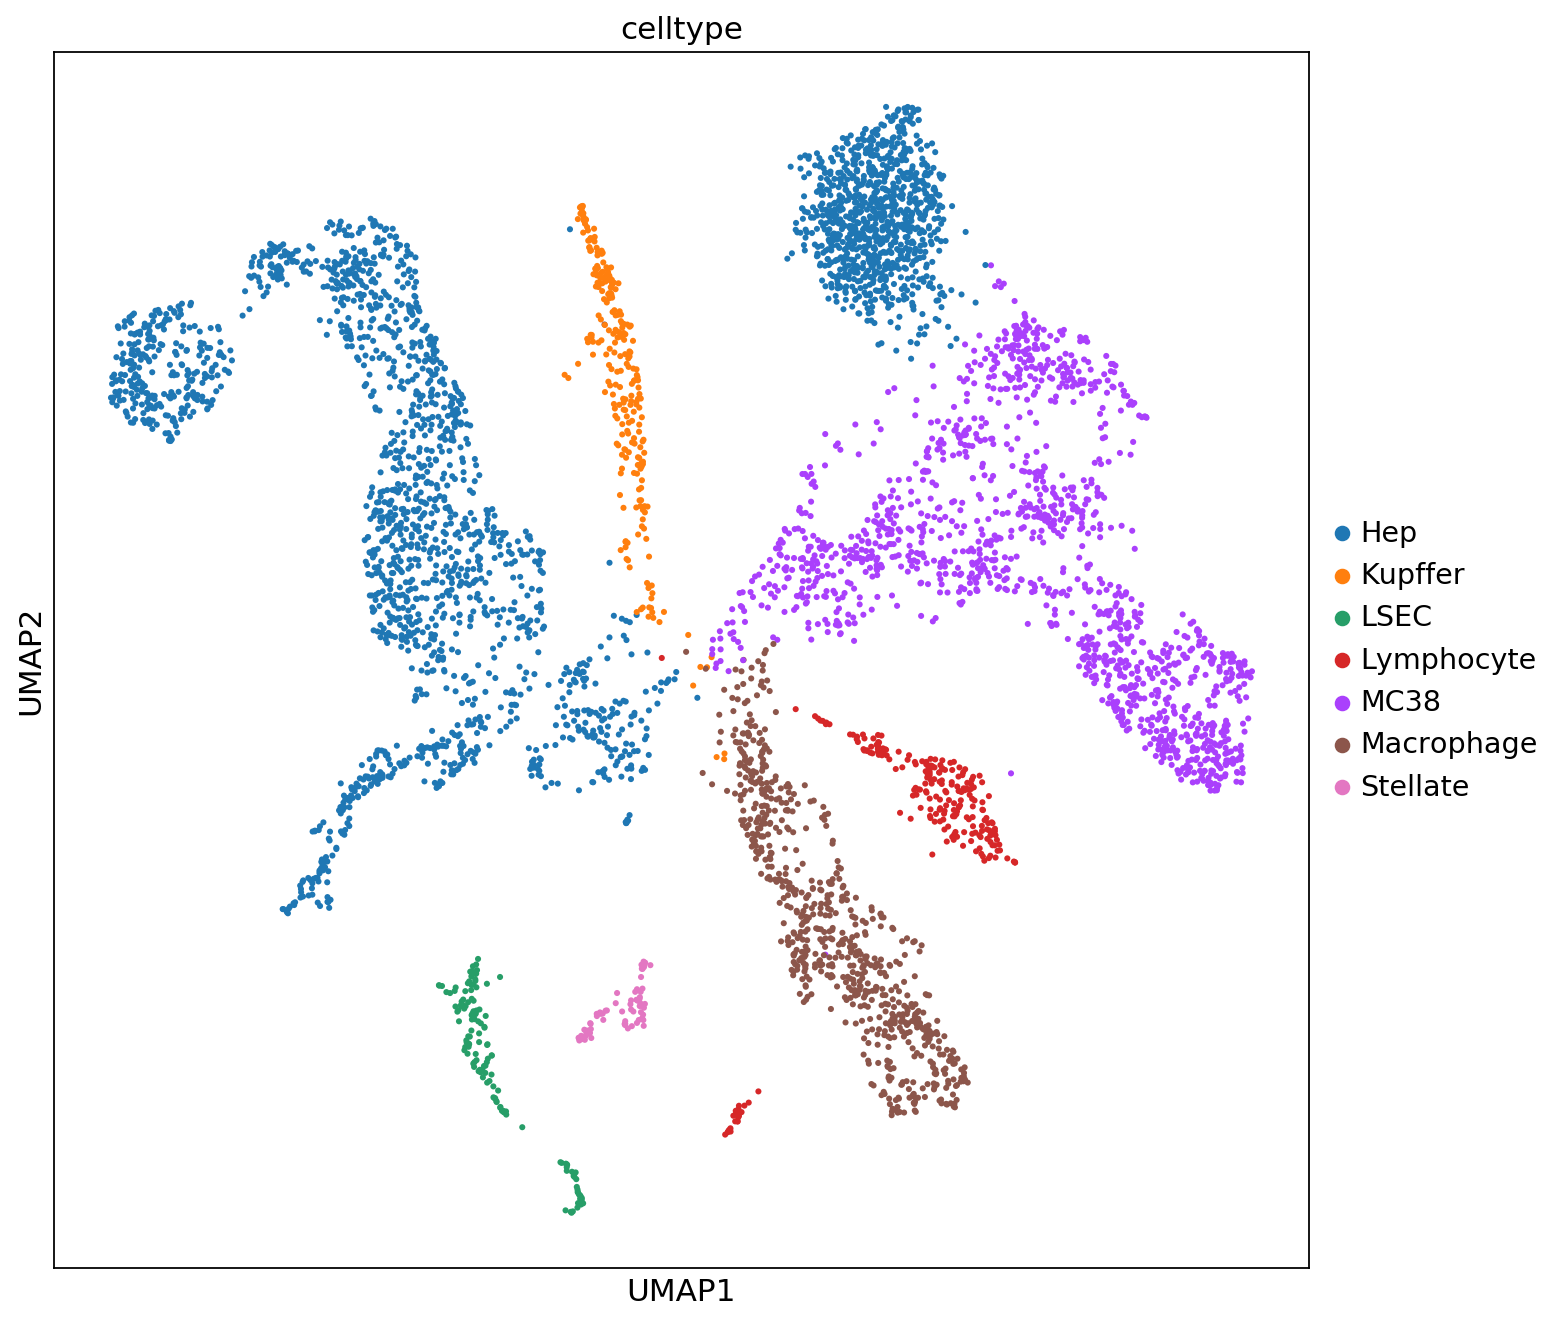

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat, color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.celltype.pdf')

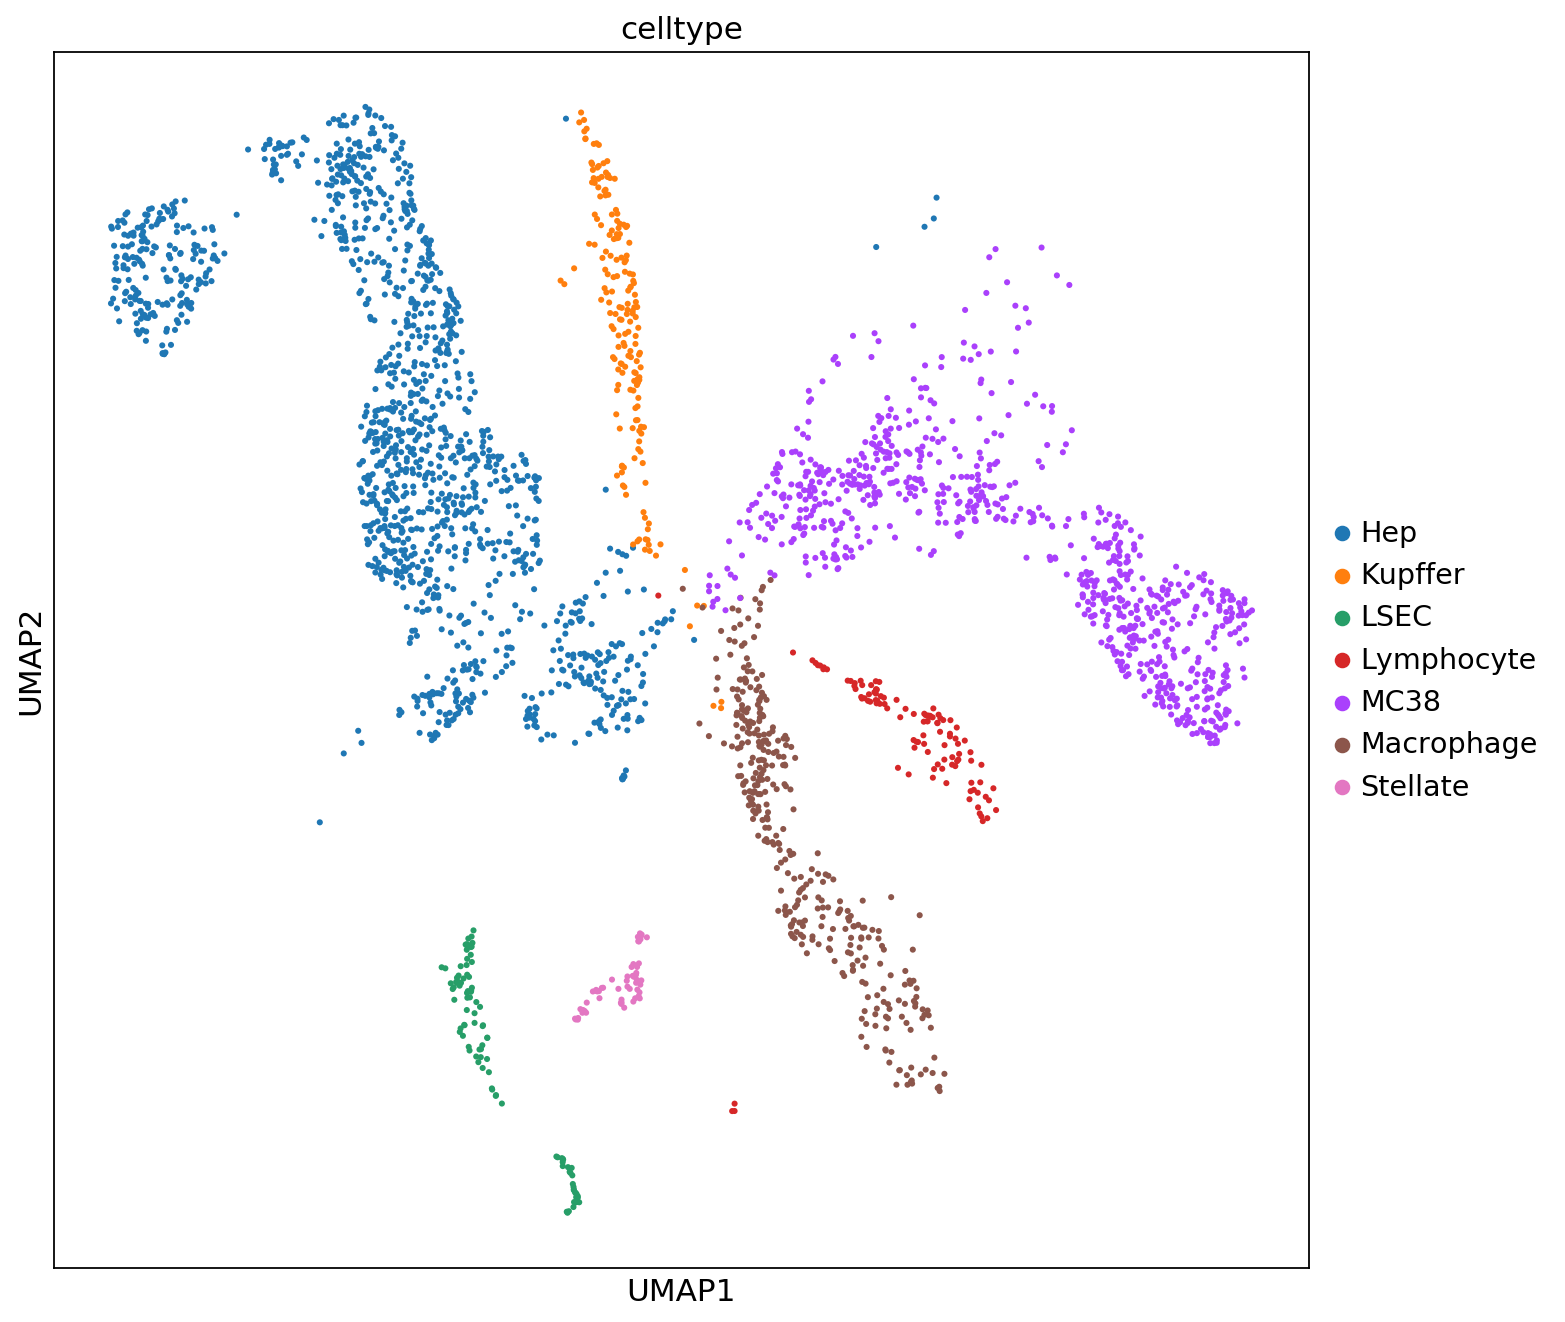

In [79]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat[concat.obs['batch'] == 'XYZeq'], color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.XYZeq.only.pdf')

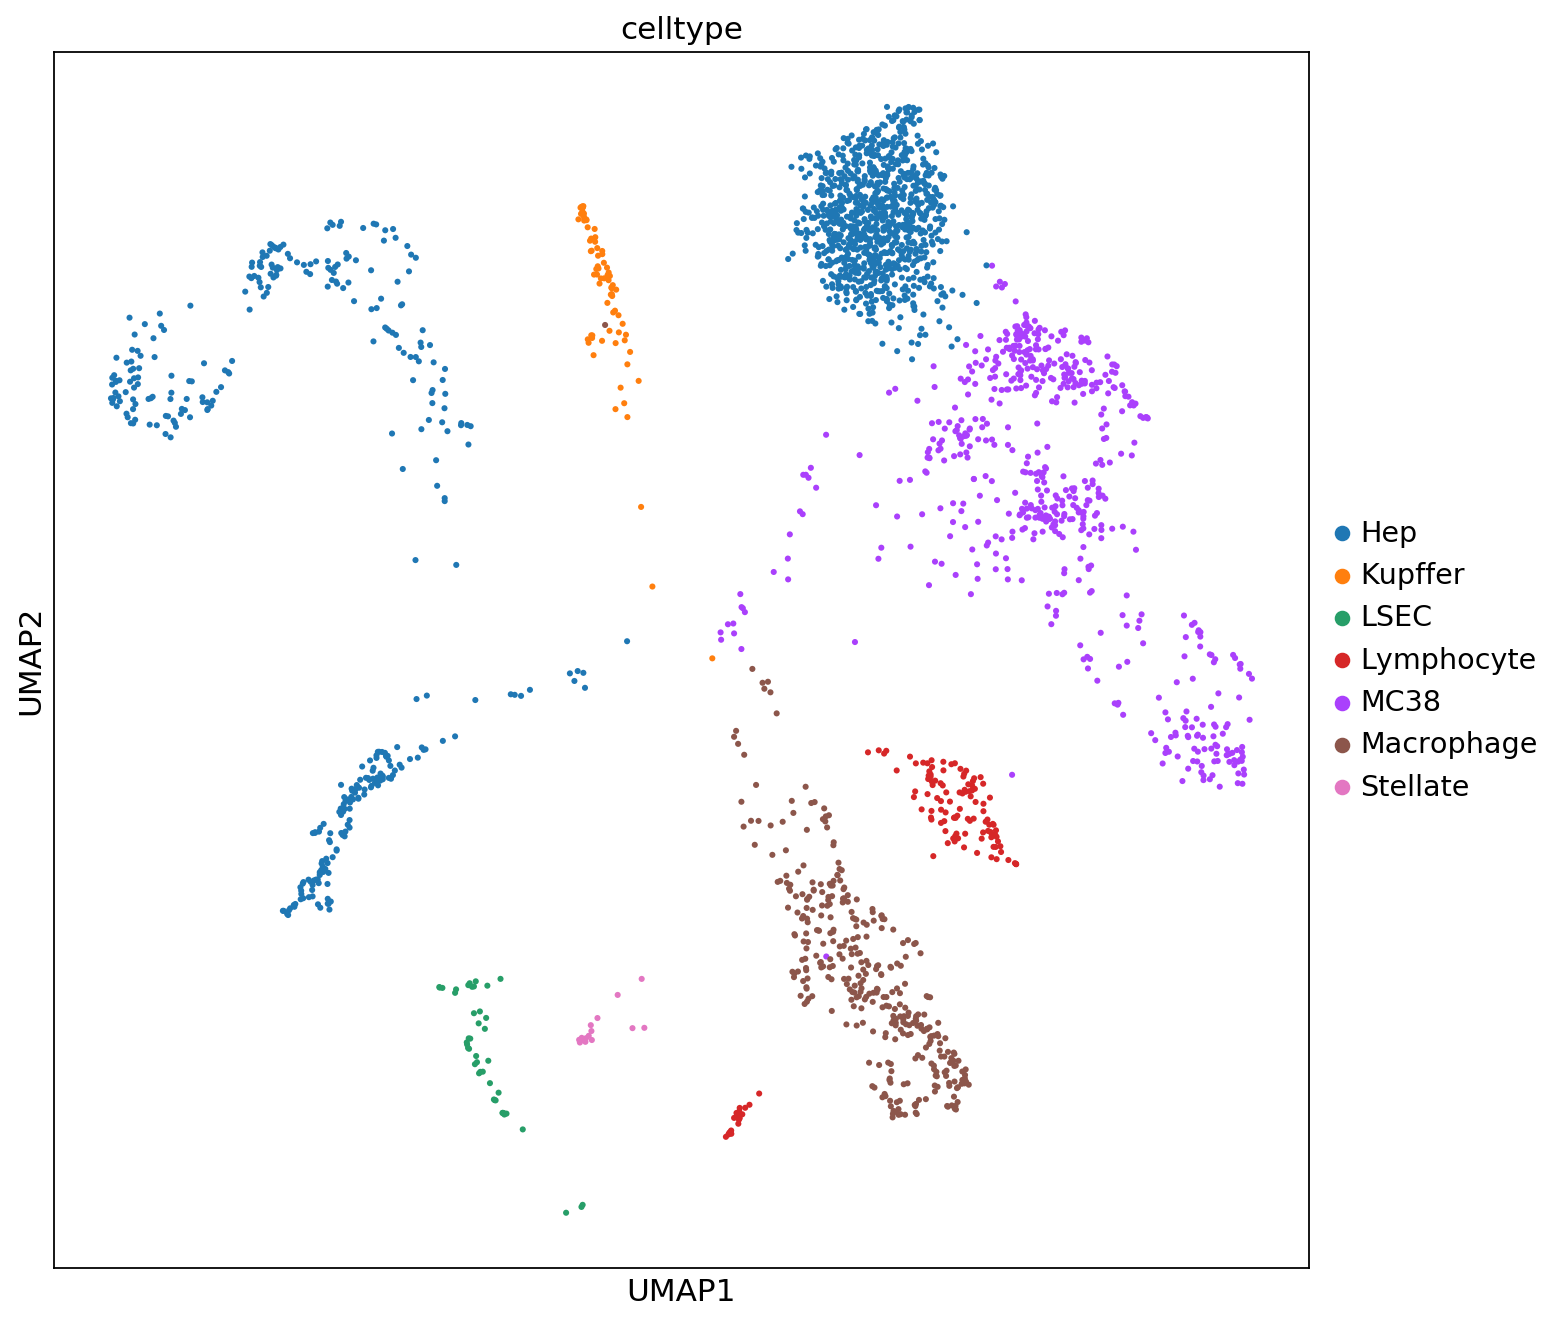

In [91]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat[concat.obs['batch'] == '10x'], color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.XYZeq.only.pdf')

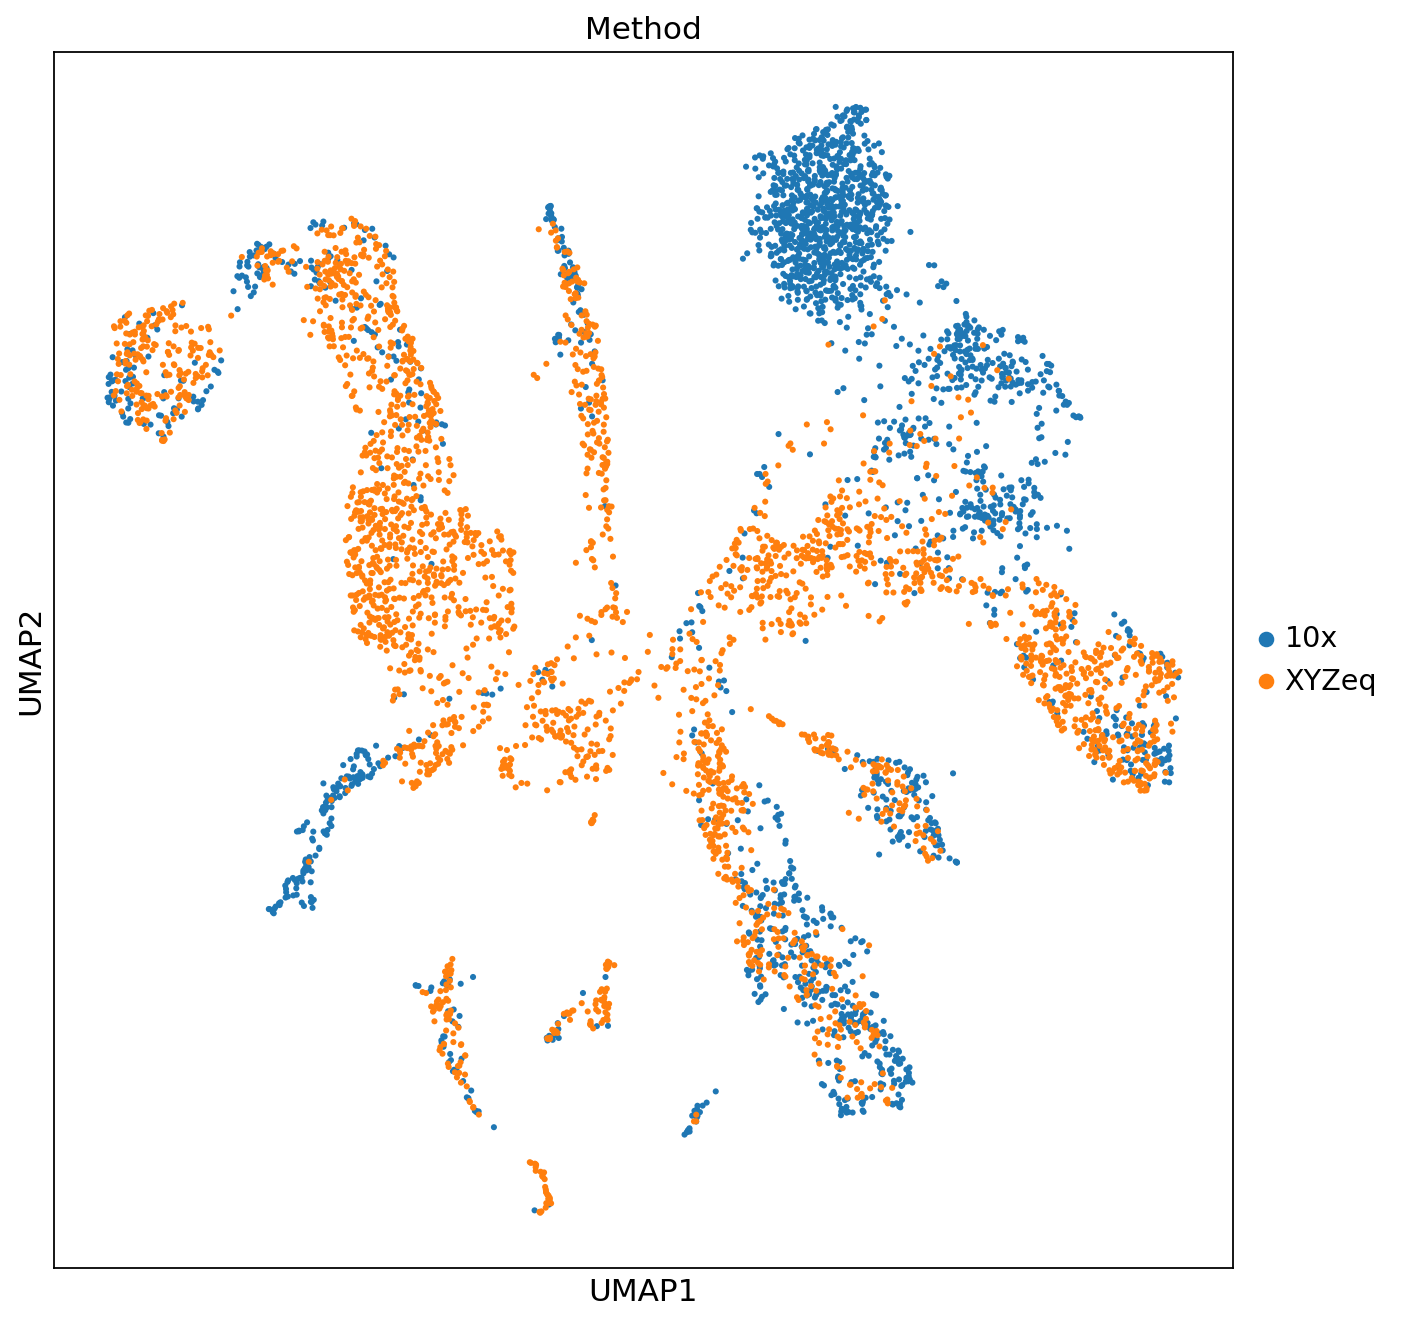

In [445]:
fig, ax = plt.subplots(1,1,figsize=(9,8.5))
sc.pl.umap(concat,color=['batch'], size=30, ax=ax, return_fig=False, show=False, title='Method')
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.10x.only.pdf')

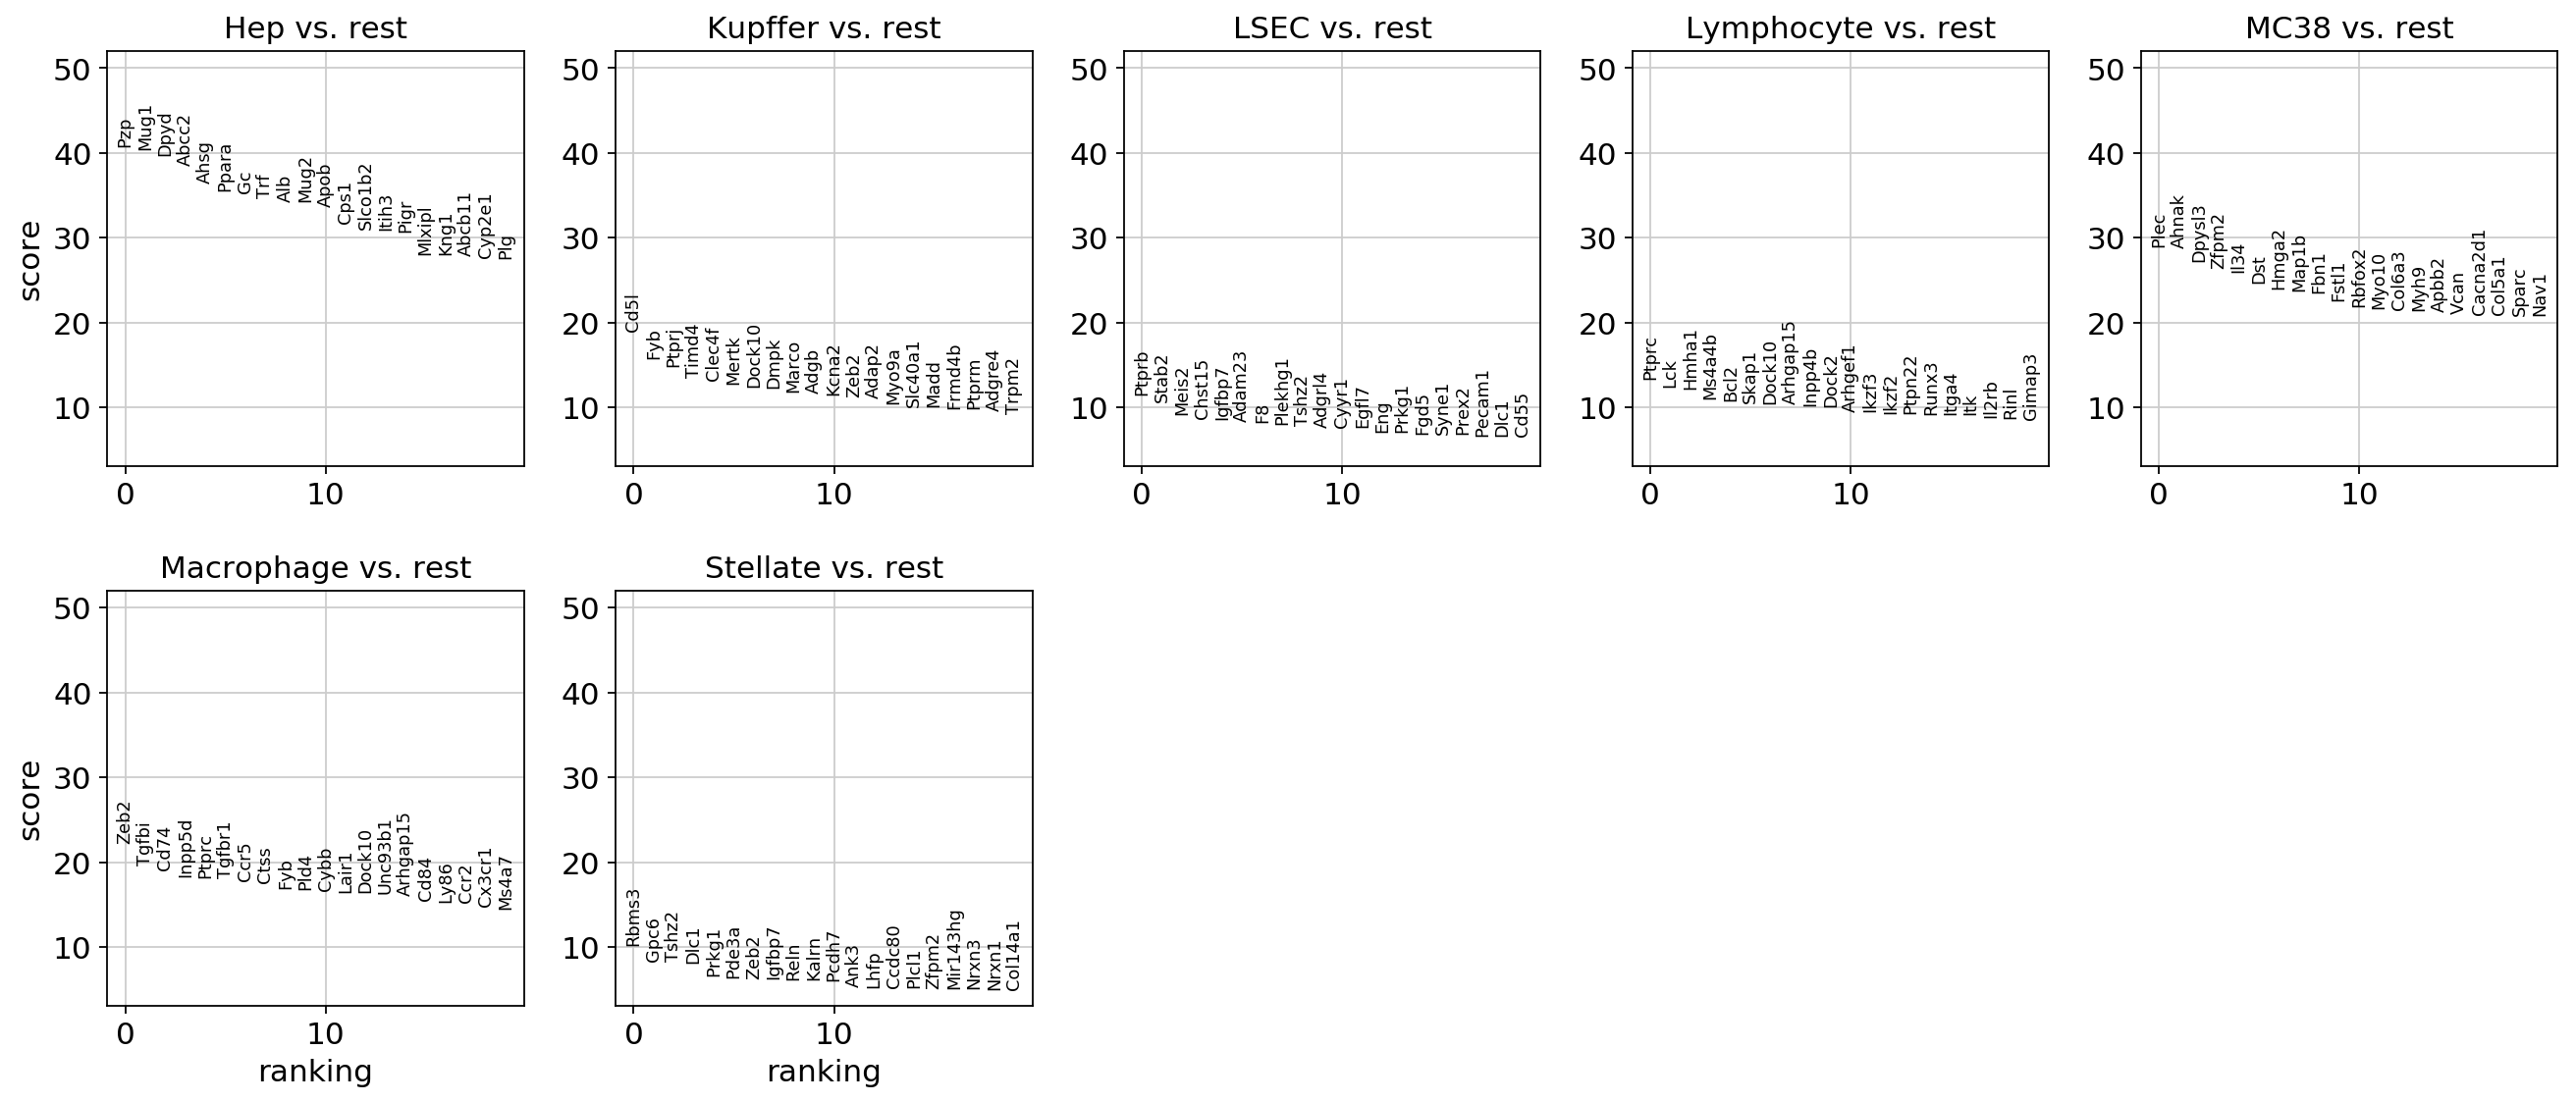

In [92]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat,groupby='celltype')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 3

In [93]:
groups = concat.obs['celltype'].unique()

In [94]:
groups

[MC38, Hep, LSEC, Macrophage, Stellate, Kupffer, Lymphocyte]
Categories (7, object): [MC38, Hep, LSEC, Macrophage, Stellate, Kupffer, Lymphocyte]

In [ ]:
gsea_dicts = dict()
for i in tqdm(groups):
    gsea_dicts[i] = dict()
    print(i)
    gsea_dicts[i]['enrichr'] = enrichr(list(concat.uns['rank_genes_groups']['names'][i][:25]), plot=True)
    gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error

### Correlate proportion in each Leiden cluster

In [99]:
group_counts = list()
for group in groups: # groups defined earlier
    batches = concat[concat.obs['celltype'] == group].obs['batch'].values
    vals, counts = np.unique(batches, return_counts=True)
    group_counts.append(counts)

In [100]:
vals, batch_counts = np.unique(concat.obs['batch'].values, return_counts=True)

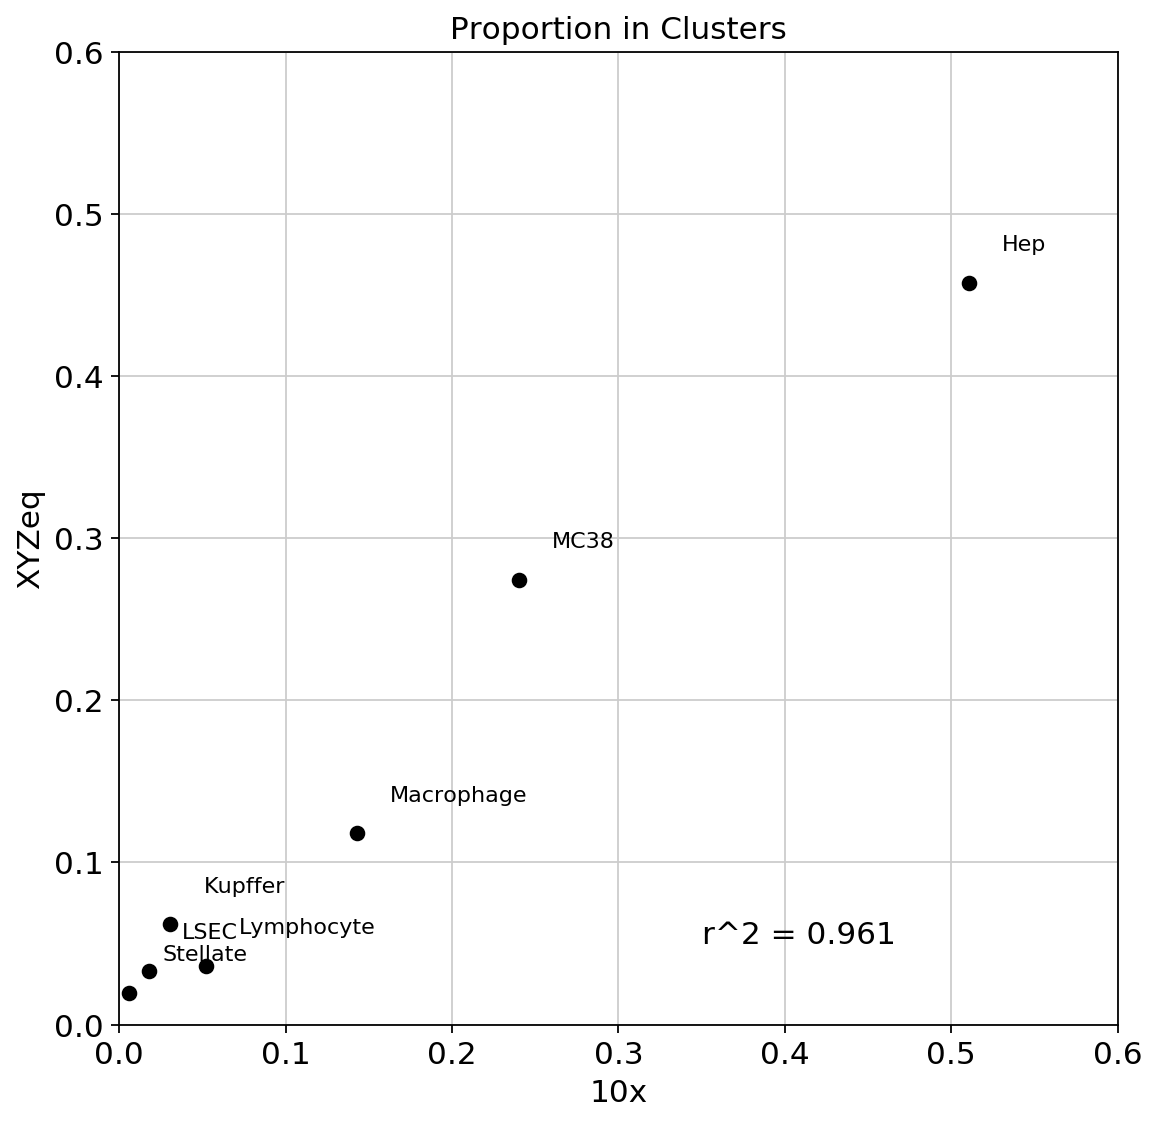

In [101]:
x = [i[0]/batch_counts[0] for i in group_counts]
y = [i[1]/batch_counts[1] for i in group_counts]
n = groups

plt.figure(figsize=(8,8))
plt.scatter(x, y, color='k');
plt.title('Proportion in Clusters')
plt.xlabel('%s' % vals[0])
plt.ylabel('%s' % vals[1])
plt.xlim(0,0.6)
plt.xticks(np.arange(0, 0.7, 0.1))
plt.ylim(0,0.6)
ax = plt.gca()
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.02, y[i]+0.02), size=10)

# The difference between correlation and coefficient of determination
# They can correlate, but that's not what I want to see. I want to see how well they fit the model that the proportions should be identical, x = y
# is the r2_score() command right then?

# r = pearsonr(x,y)[0]
r2 = r2_score(y_true=y, y_pred=x)

# plt.text(0.2, 0.01, 'pearsonr = ' + str(r)[:5]);
plt.text(0.35, 0.05, 'r^2 = ' + str(r2)[:5]);
plt.savefig(prefix + '10x/20191102/figures/correlate.proportion.pdf')

## Make Bubble Plot

Define the genes we want to look at in the bubble plot.

In [266]:
genes = dict()
cts = ['Hep', 'LSEC', 'Stellate', 'MC38', 'Kupffer', 'Macrophage', 'Lymphocyte']
for ct in cts: # good order for visualizing in bubble plot
    ct_genes = [i for i in concat.uns['rank_genes_groups']['names'][ct]]
    genes[ct] = [i for i in concat.uns['rank_genes_groups']['names'][ct][:10]]

In [267]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse

In [268]:
genes_inv = invert_dict(genes)

In [269]:
genes_list = np.array([i for j in genes.values() for i in j])

Generate two DataFrames, one with the percentage of cells expressing per cell type, and the other with the mean expression of the gene for each cell type.

In [270]:
percentdf = pd.DataFrame(np.zeros((len(cts),len(genes_list))),index=cts,columns=genes_list)
expdf = pd.DataFrame(np.zeros((len(cts),len(genes_list))),index=cts,columns=genes_list)

Fill in the DataFrames I instantiated.

In [272]:
for gene in tqdm(genes_list):
    for ct in cts:
        vals = concat[concat.obs['celltype'] == ct].obs_vector(gene).copy()
        percentdf.loc[ct,gene] = sum(vals > 0)/len(vals)
        expdf.loc[ct,gene] = vals.mean()

Normalize the expression DataFrame in order to 1. mute the expression level for those cell types that have one below the manually defined thresholds, since this is likely just capturing noise, and 2. normalize to the expression level of the most-highly expressing cell type.

In [273]:
expdf_norm = expdf.copy()

In [274]:
for gene in expdf_norm:
    genemin = expdf_norm[gene].min()
    expdf_norm[gene] = expdf_norm[gene] - genemin # shift such that the min is zero
    val = genemin
    if type(val) == pd.Series:
        val = val.iloc[0]
    expdf_norm[gene] = np.where(expdf_norm[gene].values > val, expdf_norm[gene].values, 0) # replace anything below zero with zero
expdf_norm = expdf_norm.div(expdf_norm.sum(axis=0), axis=1)
expdf_norm = expdf_norm.fillna(0)

Plot it.

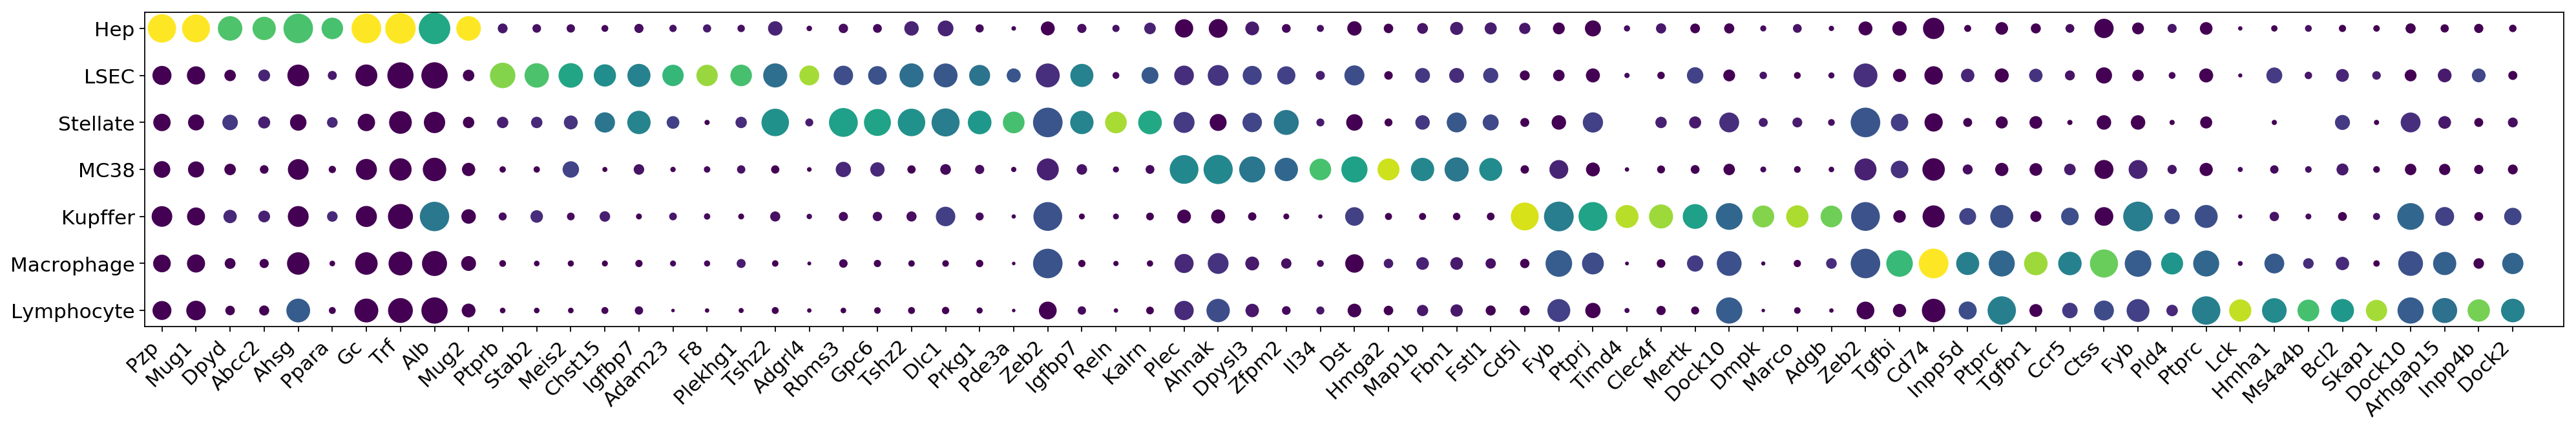

In [276]:
plt.figure(figsize=(30,4))
plt.scatter([i[::-1][0] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes_list)))], 
            [i[::-1][1] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes_list)))], 
            s=500*np.ravel(percentdf.values), 
            c=np.ravel(expdf_norm.values));
plt.xticks(range(len(genes_list)),labels=genes_list, rotation=45)
plt.yticks(range(len(cts)),labels=cts[::-1])
plt.xlim(-0.5,len(cts)*len(genes['Hep']) + 0.5)
plt.grid(False)
ax = plt.gca()
ax.set_xticklabels(genes_list, ha='right')
plt.savefig(prefix + '10x/20191102/figures/10x.L20C1.bubble.pdf')